In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap
from nltk.corpus import stopwords
import numpy as np
from PIL import Image
from wordcloud import WordCloud, ImageColorGenerator, STOPWORDS
from concurrent.futures import ThreadPoolExecutor, as_completed
import seaborn as sns
import nltk
nltk.download('stopwords')
from nltk.collocations import BigramCollocationFinder
from nltk.collocations import TrigramCollocationFinder
from nltk.metrics import BigramAssocMeasures
from nltk.metrics import TrigramAssocMeasures
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
nltk.download('punkt')
from transformers import pipeline
from tqdm import tqdm
from google.colab import drive
import requests


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


In [ ]:
!pip install gliner

# Loading the Dataframe

In [ ]:
drive.mount('/content/drive')


Mounted at /content/drive


In [ ]:
file_path = '/content/drive/My Drive/Barshuka/reviews_06_06_24.csv'
df = pd.read_csv(file_path)

In [ ]:
df.head(10)

,source,venue_name,review_date,overall_rating,food,service,ambience,noise_text,answer,wait staff_name,...,guest_name,guest_phone,guest_email,total_spend,total_visits,birthday,recommended,nps_answer,nps_type,response
0,OpenTable,BarShuka,2024-06-05,5,5.0,4.0,5.0,NaN,NaN,NaN,...,Guest,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,Google,BarShuka,2024-06-04,4,NaN,NaN,NaN,NaN,"Super Lokal im Bahnhofviertel, um lecker Essen...",NaN,...,Rahel N. Witteck,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,OpenTable,BarShuka,2024-06-02,5,5.0,5.0,5.0,Quiet,"1: As always, a pleasure! Vegan, vegetarian, m...",NaN,...,Guest,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN
3,Google,BarShuka,2024-06-02,1,NaN,NaN,NaN,NaN,NaN,NaN,...,Donya Sayed,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,Google,BarShuka,2024-06-01,4,NaN,NaN,NaN,NaN,"Guter, schneller und netter Service. Sehr schn...",NaN,...,Vincent,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,OpenTable,BarShuka,2024-05-31,4,4.0,4.0,4.0,NaN,NaN,NaN,...,Guest,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6,Google,BarShuka,2024-05-31,5,NaN,NaN,NaN,NaN,NaN,NaN,...,Juliana Bertanha,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7,Google,BarShuka,2024-05-31,1,NaN,NaN,NaN,NaN,Waren heute in der Gruppe um 19 Uhr bei euch g...,NaN,...,Mario Dietz,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"Hi Mario,\nmein Name ist James und ich bin ein..."
8,OpenTable,BarShuka,2024-05-30,5,5.0,5.0,4.0,Quiet,NaN,NaN,...,Guest,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN
9,OpenTable,BarShuka,2024-05-30,5,5.0,5.0,5.0,NaN,NaN,NaN,...,ILBF,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


# Language classification for text

To check which reviews might have to get translated

In [ ]:
df['answer'] = df['answer'].replace('\n', ' ', regex=True)
# Drop rows where 'answer' is NaN
df_clean = df.dropna(subset=['answer'])


In [ ]:
df["answer"][1]

'Super Lokal im Bahnhofviertel, um lecker Essen zu gehen. Das Lokal hat zustzlich zu dem Innenbereich eine Terasse im Innenhof und eine Dachterasse.'

In [ ]:
model_ckpt = "papluca/xlm-roberta-base-language-detection"
pipe = pipeline("text-classification", model=model_ckpt)

# Function to apply the language detection model to a text
def detect_language(text):
    try:
        result = pipe(text, top_k=1, truncation=True)
        language = result[0]['label']
        return language
    except Exception as e:
        print(f"Error processing text: {e}")
        return "Error"

# Function to parallelize language detection
def parallel_detect_language(texts):
    languages = [None] * len(texts)  # Pre-allocate a list to store the results
    with ThreadPoolExecutor() as executor:
        # Submit all tasks to the executor
        futures = [executor.submit(detect_language, text) for text in texts]

        # Process the results as they complete
        for future in tqdm(as_completed(futures), total=len(futures), desc="Detecting Languages"):
            try:
                result = future.result()
                # Find the index of this future and assign the result
                index = futures.index(future)
                languages[index] = result
            except Exception as e:
                print(f"Error in parallel execution: {e}")
    return languages

# Apply the parallelized language detection function to the 'review_text' column
df_clean['language_label'] = parallel_detect_language(df_clean['answer'].tolist())


/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/1.42k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/1.11G [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/502 [00:00<?, ?B/s]

sentencepiece.bpe.model:   0%|          | 0.00/5.07M [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/9.08M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/239 [00:00<?, ?B/s]

Detecting Languages: 100%|██████████| 217/217 [00:57<00:00,  3.75it/s]
<ipython-input-10-1dcf260ed68a>:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_clean['language_label'] = parallel_detect_language(df_clean['answer'].tolist())


In [ ]:
df_clean["language_label"].value_counts()

language_label
de    160
en     54
es      1
pt      1
ur      1
Name: count, dtype: int64

In [ ]:
# Filter the DataFrame to include only rows where the language is neither English nor German
non_en_de_texts = df_clean[~df_clean['language_label'].isin(['en', 'de'])]

# Display these rows - focusing on the text and language label columns
print(non_en_de_texts[['answer', 'language_label']])


                                                answer language_label
23   1: Comida muy sabrosa y servicio rpido y amabl...             es
118  A melhor experincia que tive em Frankfurt! Com...             pt
167                                                Bon             ur


In [ ]:
df_deutsch = df_clean[df_clean['language_label'] == 'de']  # DataFrame with German language reviews
df_other = df_clean[df_clean['language_label'] != 'de']

# Translate the non german Reviews


In [ ]:
def translate_text_with_deepl(text, target_lang, auth_key):
    translate_url = "https://api-free.deepl.com/v2/translate"
    headers = {
        'Authorization': f'DeepL-Auth-Key {auth_key}'
    }
    data = {
        'text': text,
        'target_lang': target_lang
    }
    try:
        response = requests.post(translate_url, headers=headers, data=data)
        if response.status_code == 200:
            json_response = response.json()
            translated_text = json_response['translations'][0]['text']
            return translated_text
        else:
            print(f"Translation failed: {response.status_code}, {response.text}")
    except Exception as e:
        print(f"Error during translation: {e}")
    return text  # Return the original text if translation fails

def translate_texts(texts, target_lang, auth_key, max_workers=10):
    # Using an ordered dictionary to preserve the insertion order
    translations = {i: None for i in range(len(texts))}  # Preserving order with indices
    with ThreadPoolExecutor(max_workers=max_workers) as executor:
        # Mapping of futures to their corresponding index
        future_to_index = {executor.submit(translate_text_with_deepl, text, target_lang, auth_key): i for i, text in enumerate(texts)}

        # Collecting the results as they are completed
        for future in tqdm(as_completed(future_to_index), total=len(texts), desc="Translating"):
            index = future_to_index[future]
            translations[index] = future.result()  # Storing the result at the correct index

    # Return the ordered results based on the original index
    return [translations[i] for i in range(len(texts))]

# Sample usage

auth_key = "auth_key"  # Replace this with your actual DeepL API key
target_lang = "DE"

translated_texts = translate_texts(df_other['answer'].tolist(), target_lang, auth_key, max_workers=5)

# Update the DataFrame with the translated texts
df_other['translated_text'] = translated_texts


Translating: 100%|██████████| 57/57 [00:06<00:00,  8.20it/s]
<ipython-input-14-34c9b2abf9c0>:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_other['translated_text'] = translated_texts


In [ ]:
df_other.head(10)

,source,venue_name,review_date,overall_rating,food,service,ambience,noise_text,answer,wait staff_name,...,guest_email,total_spend,total_visits,birthday,recommended,nps_answer,nps_type,response,language_label,translated_text
2,OpenTable,BarShuka,2024-06-02,5,5.0,5.0,5.0,Quiet,"1: As always, a pleasure! Vegan, vegetarian, m...",NaN,...,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,en,"1: Wie immer, ein Vergnügen! Veganer, Vegetari..."
11,Google,BarShuka,2024-05-28,3,NaN,NaN,NaN,NaN,The restaurants decor and ambiance were fun. S...,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,en,Die Einrichtung und das Ambiente des Restauran...
22,Google,BarShuka,2024-05-04,5,NaN,NaN,NaN,NaN,Delicious food but a little overpriced. Great ...,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,en,"Leckeres Essen, aber ein wenig überteuert. Tol..."
23,OpenTable,BarShuka,2024-05-03,5,5.0,5.0,5.0,NaN,1: Comida muy sabrosa y servicio rpido y amabl...,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,es,1: Sehr leckeres Essen und schnelle und freund...
25,OpenTable,BarShuka,2024-05-02,4,4.0,3.0,4.0,NaN,1: The lunch menu is a little short but we ate...,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,en,"1: Das Mittagsmenü ist ein wenig kurz, aber wi..."
28,Google,BarShuka,2024-05-01,5,NaN,NaN,NaN,NaN,"I love this place. Very nice atmosphere, delic...",NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,en,"Ich liebe diesen Ort. Sehr schöne Atmosphäre, ..."
44,Google,BarShuka,2024-04-17,5,NaN,NaN,NaN,NaN,"Love the food, the drinks, the people. It's mo...",NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,en,"Ich liebe das Essen, die Getränke und die Mens..."
47,OpenTable,BarShuka,2024-04-13,5,5.0,5.0,5.0,NaN,1: Great place for sharing and trying a bunch ...,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,en,"1: Ein großartiger Ort, um zu teilen und an ei..."
54,Google,BarShuka,2024-04-06,1,NaN,NaN,NaN,NaN,"Super bad food. Bland, no flavours, wine and d...",NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,en,"Super schlechtes Essen. Fade, keine Aromen, We..."
69,TripAdvisor,BarShuka,2024-03-25,4,NaN,NaN,NaN,NaN,Lost my details of my last TA account.....urrg...,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,en,Ich habe die Daten meines letzten TA-Kontos......


In [ ]:
df_deutsch["translated_text"] = df_deutsch["answer"]

<ipython-input-16-29c6dfac884e>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_deutsch["translated_text"] = df_deutsch["answer"]


In [ ]:
# Assuming df_de and df_other are your two DataFrames and both have a 'translated_text' column added to them
df_translated = pd.concat([df_deutsch, df_other])

# Optionally, you might want to reset the index of the merged DataFrame to ensure it's continuous and without duplicates
df_translated.reset_index(drop=True, inplace=True)

In [ ]:
df_translated.shape

(217, 23)

In [ ]:
df.to_csv('/content/drive/My Drive/Barshuka/df.csv', index=False)
df_translated.to_csv('/content/drive/My Drive/Barshuka/df_translated.csv', index=False)


language classification and translation end here

# Basic Insights

In [1]:
file_path = '/content/drive/My Drive/Barshuka/df_classified_ner.csv'
df_translated = pd.read_csv(file_path)

NameError: name 'pd' is not defined

## Word Clouds

In [2]:
text = df_translated['translated_text'].str.cat(sep=' ')


NameError: name 'df_translated' is not defined

In [ ]:
#set the stopwords list
# Load the German stopwords and convert them into a set
german_stopwords = set(stopwords.words('german'))

# Define your new words to add to the stopwords list and convert it into a set
new_words = set(["Barshuka", "Bar Shuka", "barshuka", "bar shuka", "sie","fr" ,"ich", "Ich", "der", "ein", "hat", "von", "man", "eine", "bei", "zu", "war", "mir", "da", "nach", "auch", "ihnen", "das", "dass", "e", "auf", "ist", "de", "mit dem", "mit", "die", "habe", "aber", "einen", "wurde", "nicht", "für", "um", "dann", "es", "einem", "wenn", "den", "dem","immer","mehr","nie"])

# Combine the original stopwords with the new ones using set union
new_stopwords = german_stopwords.union(new_words)

In [ ]:
python_mask = np.array(Image.open("/content/kopf2.png"))  # Replace with your image path


# Create the word cloud using the mask
wc = WordCloud(
    stopwords=new_stopwords,  # Assuming you have defined 'new_stopwords' somewhere
    mask=python_mask,
    background_color="white",
    contour_color="black",
    contour_width=1,
    min_font_size=3,
    max_words=100,
    color_func=lambda *args, **kwargs: "black"  # Force all text to be black
).generate(text)  # Replace 'text' with your actual text data

# Display the generated word cloud
plt.imshow(wc, interpolation='bilinear')
plt.axis("off")
plt.show()

In [3]:
df_bad = df_translated[df_translated['overall_rating'].isin([1, 2, 3])]


NameError: name 'df_translated' is not defined

In [ ]:
text_bad = df_bad['translated_text'].str.cat(sep=' ')


In [ ]:
python_mask = np.array(Image.open("/content/kopf2.png"))  # Replace with your image path


# Create the word cloud using the mask
wc = WordCloud(
    stopwords=new_stopwords,  # Assuming you have defined 'new_stopwords' somewhere
    mask=python_mask,
    background_color="white",
    contour_color="black",
    contour_width=1,
    min_font_size=3,
    max_words=100,
    color_func=lambda *args, **kwargs: "black"  # Force all text to be black
).generate(text_bad)  # Replace 'text' with your actual text data

# Display the generated word cloud
plt.imshow(wc, interpolation='bilinear')
plt.axis("off")
plt.show()

## Bigramms and Digramms

In [ ]:
# Tokenize the text
tokens = word_tokenize(text)

# Remove stopwords and non-alphabetic tokens
tokens = [word.lower() for word in tokens if word.isalpha() and word.lower() not in new_stopwords]

# Create bigram and trigram finders
bigram_finder = BigramCollocationFinder.from_words(tokens)
trigram_finder = TrigramCollocationFinder.from_words(tokens)

# Score the ngrams by frequency
bigrams = bigram_finder.ngram_fd.items()
trigrams = trigram_finder.ngram_fd.items()

# Sort them in descending order of frequency
sorted_bigrams = sorted(bigrams, key=lambda item: item[1], reverse=True)
sorted_trigrams = sorted(trigrams, key=lambda item: item[1], reverse=True)

# Display the top 10 bigrams and trigrams
print("Top 10 bigrams:", sorted_bigrams[:10])
print("Top 10 trigrams:", sorted_trigrams[:10])

In [ ]:
tokens = word_tokenize(text_bad)

# Remove stopwords and non-alphabetic tokens
tokens = [word.lower() for word in tokens if word.isalpha() and word.lower() not in new_stopwords]

# Create bigram and trigram finders
bigram_finder = BigramCollocationFinder.from_words(tokens)
trigram_finder = TrigramCollocationFinder.from_words(tokens)

# Score the ngrams by frequency
bigrams = bigram_finder.ngram_fd.items()
trigrams = trigram_finder.ngram_fd.items()

# Sort them in descending order of frequency
sorted_bigrams = sorted(bigrams, key=lambda item: item[1], reverse=True)
sorted_trigrams = sorted(trigrams, key=lambda item: item[1], reverse=True)

# Display the top 10 bigrams and trigrams
print("Top 10 bigrams:", sorted_bigrams[:10])
print("Top 10 trigrams:", sorted_trigrams[:10])

# Text Classification

In [ ]:
candidate_labels = ["Essen","Getränke","Service","Speisekarte","Preis","Hygiene","Ambiente"]

In [ ]:
headers = {
    "api_key" #replace with your api key
}

def query_huggingface_api(text, candidate_labels):
    API_URL = "your api-key" # replace with your hugging face api_key
    payload = {
        "inputs": text,
        "parameters": {"candidate_labels": candidate_labels, "multi_label": True}
    }
    response = requests.post(API_URL, headers=headers, json=payload)
    if response.status_code == 200:
        response_json = response.json()
        return response_json
    else:
        raise Exception(f"Failed to query the API: {response.status_code}, {response.text}")


# Function to process the results and filter by score threshold
def get_labels_and_scores(api_response):
    labels_and_scores = zip(api_response['labels'], api_response['scores'])
    # Check if any score is above the threshold
    above_threshold = any(score > 0.5 for score in api_response['scores'])

    if above_threshold:
        # Filter labels and scores above the threshold
        filtered_labels_and_scores = [(label, score) for label, score in labels_and_scores if score > 0.5]
    else:
        # Take the label with the highest score
        highest_score_index = api_response['scores'].index(max(api_response['scores']))
        filtered_labels_and_scores = [(api_response['labels'][highest_score_index], api_response['scores'][highest_score_index])]

    # Unpack the labels and scores
    labels, scores = zip(*filtered_labels_and_scores)
    return labels, scores

# Apply the API query function to each row in the DataFrame
# We will use tqdm to display a progress bar
results = []
for text in tqdm(df_translated['translated_text'], desc="Classifying"):
    api_response = query_huggingface_api(text, candidate_labels)
    labels, scores = get_labels_and_scores(api_response)
    results.append((labels, scores))

df_translated['labels'], df_translated['labels_score'] = zip(*results)

Classifying: 100%|██████████| 217/217 [02:28<00:00,  1.46it/s]


In [ ]:
df_translated.head(10)

,source,venue_name,review_date,overall_rating,food,service,ambience,noise_text,answer,wait staff_name,...,total_visits,birthday,recommended,nps_answer,nps_type,response,language_label,translated_text,labels,labels_score
0,Google,BarShuka,2024-06-04,4,NaN,NaN,NaN,NaN,"Super Lokal im Bahnhofviertel, um lecker Essen...",NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,de,"Super Lokal im Bahnhofviertel, um lecker Essen...","(Essen, Hygiene)","(0.9901278614997864, 0.9019485116004944)"
1,Google,BarShuka,2024-06-01,4,NaN,NaN,NaN,NaN,"Guter, schneller und netter Service. Sehr schn...",NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,de,"Guter, schneller und netter Service. Sehr schn...","(Service, Essen, Hygiene, Ambiente)","(0.9916689395904541, 0.9890152812004089, 0.563..."
2,Google,BarShuka,2024-05-31,1,NaN,NaN,NaN,NaN,Waren heute in der Gruppe um 19 Uhr bei euch g...,NaN,...,NaN,NaN,NaN,NaN,NaN,"Hi Mario,\nmein Name ist James und ich bin ein...",de,Waren heute in der Gruppe um 19 Uhr bei euch g...,"(Hygiene,)","(0.34366685152053833,)"
3,Google,BarShuka,2024-05-25,5,NaN,NaN,NaN,NaN,"Netter Empfang und sofern Platz ist, kann man ...",NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,de,"Netter Empfang und sofern Platz ist, kann man ...","(Speisekarte, Preis)","(0.7329637408256531, 0.7232328653335571)"
4,OpenTable,BarShuka,2024-05-22,5,5.0,5.0,5.0,Quiet,"1: Immer wieder ganz wunderbar, um mit Freunde...",NaN,...,NaN,NaN,1.0,NaN,NaN,NaN,de,"1: Immer wieder ganz wunderbar, um mit Freunde...","(Essen,)","(0.9937493205070496,)"
5,Google,BarShuka,2024-05-22,5,NaN,NaN,NaN,NaN,Ich was spontan mit etwas Hunger zur Mittagsze...,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,de,Ich was spontan mit etwas Hunger zur Mittagsze...,"(Ambiente, Speisekarte)","(0.9948623180389404, 0.5205345749855042)"
6,Google,BarShuka,2024-05-08,5,NaN,NaN,NaN,NaN,Am Freitag abend ein wuseliger Ort. Um 22 Uhr ...,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,de,Am Freitag abend ein wuseliger Ort. Um 22 Uhr ...,"(Essen, Service)","(0.9909074306488037, 0.9744383096694946)"
7,OpenTable,BarShuka,2024-05-03,5,5.0,5.0,5.0,NaN,"1: Schon beim Betreten fhlt man sich, als wre ...",NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,de,"1: Schon beim Betreten fhlt man sich, als wre ...","(Speisekarte, Essen)","(0.9360092282295227, 0.8321100473403931)"
8,OpenTable,BarShuka,2024-04-25,5,5.0,5.0,5.0,NaN,"1: Immer wieder schn. Schne Location, netter S...",NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,de,"1: Immer wieder schn. Schne Location, netter S...","(Essen, Service)","(0.9645529389381409, 0.9234471321105957)"
9,Google,BarShuka,2024-04-25,1,NaN,NaN,NaN,NaN,"Schlechtes Essen, fr viel Geld. Langweilige, a...",NaN,...,NaN,NaN,NaN,NaN,NaN,Vielen Dank für Deine wohlwollende Bewertung v...,de,"Schlechtes Essen, fr viel Geld. Langweilige, a...","(Essen,)","(0.9914324879646301,)"


In [ ]:
df_classified = df_translated

In [ ]:
df_classified.to_csv('/content/drive/My Drive/Barshuka/df_classified.csv', index=False)


# Named Entity recognition

In [ ]:
from tqdm import tqdm
from google.colab import drive
import pandas as pd

In [ ]:
file_path = '/content/drive/My Drive/Barshuka/df_classified.csv'
df_classified = pd.read_csv(file_path)

In [ ]:
from gliner import GLiNER

model = GLiNER.from_pretrained("urchade/gliner_multi-v2.1")


/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


pytorch_model.bin:   0%|          | 0.00/1.16G [00:00<?, ?B/s]

gliner_config.json:   0%|          | 0.00/477 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/52.0 [00:00<?, ?B/s]

/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


config.json:   0%|          | 0.00/579 [00:00<?, ?B/s]

spm.model:   0%|          | 0.00/4.31M [00:00<?, ?B/s]

/usr/local/lib/python3.10/dist-packages/transformers/convert_slow_tokenizer.py:560: UserWarning: The sentencepiece tokenizer that you are converting to a fast tokenizer uses the byte fallback option which is not implemented in the fast tokenizers. In practice this means that the fast version of the tokenizer can produce unknown tokens whereas the sentencepiece version would have converted these unknown tokens into a sequence of byte tokens matching the original piece of text.
  warnings.warn(


pytorch_model.bin:   0%|          | 0.00/1.33G [00:00<?, ?B/s]

In [ ]:
def predict_entities(text, model, labels, threshold=0.5):
    # This function should return a dictionary with keys as labels and values as lists of entities
    entities = model.predict_entities(text, labels, threshold=threshold)
    result = {label: [] for label in labels}
    for entity in entities:
        result[entity["label"]].append(entity["text"])
    return result

# Modify your loop to include tqdm for a progress bar
for label in ["Personal", "Zutaten", "Zeiten"]:
    tqdm.pandas(desc=f"Processing for {label}")
    df_classified[label] = df_classified['translated_text'].progress_apply(lambda x: predict_entities(x, model, ["Personal", "Zutaten", "Zeiten"], 0.5)[label])


Processing for Zeiten: 100%|██████████| 217/217 [03:03<00:00,  1.18it/s]


In [ ]:
df_classified.head(20)

,source,venue_name,review_date,overall_rating,food,service,ambience,noise_text,answer,wait staff_name,...,nps_answer,nps_type,response,language_label,translated_text,labels,labels_score,Personal,Zutaten,Zeiten
0,Google,BarShuka,2024-06-04,4,NaN,NaN,NaN,NaN,"Super Lokal im Bahnhofviertel, um lecker Essen...",NaN,...,NaN,NaN,NaN,de,"Super Lokal im Bahnhofviertel, um lecker Essen...","('Essen', 'Hygiene')","(0.9901278614997864, 0.9019485116004944)",[],[],[]
1,Google,BarShuka,2024-06-01,4,NaN,NaN,NaN,NaN,"Guter, schneller und netter Service. Sehr schn...",NaN,...,NaN,NaN,NaN,de,"Guter, schneller und netter Service. Sehr schn...","('Service', 'Essen', 'Hygiene', 'Ambiente')","(0.9916689395904541, 0.9890152812004089, 0.563...",[],[],[]
2,Google,BarShuka,2024-05-31,1,NaN,NaN,NaN,NaN,Waren heute in der Gruppe um 19 Uhr bei euch g...,NaN,...,NaN,NaN,"Hi Mario,\nmein Name ist James und ich bin ein...",de,Waren heute in der Gruppe um 19 Uhr bei euch g...,"('Hygiene',)","(0.34366685152053833,)",[],[],[]
3,Google,BarShuka,2024-05-25,5,NaN,NaN,NaN,NaN,"Netter Empfang und sofern Platz ist, kann man ...",NaN,...,NaN,NaN,NaN,de,"Netter Empfang und sofern Platz ist, kann man ...","('Speisekarte', 'Preis')","(0.7329637408256531, 0.7232328653335571)",[],[],[]
4,OpenTable,BarShuka,2024-05-22,5,5.0,5.0,5.0,Quiet,"1: Immer wieder ganz wunderbar, um mit Freunde...",NaN,...,NaN,NaN,NaN,de,"1: Immer wieder ganz wunderbar, um mit Freunde...","('Essen',)","(0.9937493205070496,)",[],[],[]
5,Google,BarShuka,2024-05-22,5,NaN,NaN,NaN,NaN,Ich was spontan mit etwas Hunger zur Mittagsze...,NaN,...,NaN,NaN,NaN,de,Ich was spontan mit etwas Hunger zur Mittagsze...,"('Ambiente', 'Speisekarte')","(0.9948623180389404, 0.5205345749855042)",[],[],[Mittagszeit]
6,Google,BarShuka,2024-05-08,5,NaN,NaN,NaN,NaN,Am Freitag abend ein wuseliger Ort. Um 22 Uhr ...,NaN,...,NaN,NaN,NaN,de,Am Freitag abend ein wuseliger Ort. Um 22 Uhr ...,"('Essen', 'Service')","(0.9909074306488037, 0.9744383096694946)",[],[],"[Am Freitag abend, Um 22 Uhr]"
7,OpenTable,BarShuka,2024-05-03,5,5.0,5.0,5.0,NaN,"1: Schon beim Betreten fhlt man sich, als wre ...",NaN,...,NaN,NaN,NaN,de,"1: Schon beim Betreten fhlt man sich, als wre ...","('Speisekarte', 'Essen')","(0.9360092282295227, 0.8321100473403931)",[],[],[]
8,OpenTable,BarShuka,2024-04-25,5,5.0,5.0,5.0,NaN,"1: Immer wieder schn. Schne Location, netter S...",NaN,...,NaN,NaN,NaN,de,"1: Immer wieder schn. Schne Location, netter S...","('Essen', 'Service')","(0.9645529389381409, 0.9234471321105957)",[netter Service],[],[]
9,Google,BarShuka,2024-04-25,1,NaN,NaN,NaN,NaN,"Schlechtes Essen, fr viel Geld. Langweilige, a...",NaN,...,NaN,NaN,Vielen Dank für Deine wohlwollende Bewertung v...,de,"Schlechtes Essen, fr viel Geld. Langweilige, a...","('Essen',)","(0.9914324879646301,)",[],"[Zatar, Zatar]",[]


In [ ]:
df_classified.to_csv('/content/drive/My Drive/Barshuka/df_classified_ner.csv', index=False)


# Analysis

In [ ]:
drive.mount('/content/drive')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## Numerische Analyse von Ratings

In [ ]:
file_path = '/content/drive/My Drive/Barshuka/df.csv'
df = pd.read_csv(file_path)

In [ ]:
df.head(10)

,source,venue_name,review_date,overall_rating,food,service,ambience,noise_text,answer,wait staff_name,...,guest_name,guest_phone,guest_email,total_spend,total_visits,birthday,recommended,nps_answer,nps_type,response
0,OpenTable,BarShuka,2024-06-05,5,5.0,4.0,5.0,NaN,NaN,NaN,...,Guest,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,Google,BarShuka,2024-06-04,4,NaN,NaN,NaN,NaN,"Super Lokal im Bahnhofviertel, um lecker Essen...",NaN,...,Rahel N. Witteck,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,OpenTable,BarShuka,2024-06-02,5,5.0,5.0,5.0,Quiet,"1: As always, a pleasure! Vegan, vegetarian, m...",NaN,...,Guest,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN
3,Google,BarShuka,2024-06-02,1,NaN,NaN,NaN,NaN,NaN,NaN,...,Donya Sayed,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,Google,BarShuka,2024-06-01,4,NaN,NaN,NaN,NaN,"Guter, schneller und netter Service. Sehr schn...",NaN,...,Vincent,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,OpenTable,BarShuka,2024-05-31,4,4.0,4.0,4.0,NaN,NaN,NaN,...,Guest,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6,Google,BarShuka,2024-05-31,5,NaN,NaN,NaN,NaN,NaN,NaN,...,Juliana Bertanha,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7,Google,BarShuka,2024-05-31,1,NaN,NaN,NaN,NaN,Waren heute in der Gruppe um 19 Uhr bei euch g...,NaN,...,Mario Dietz,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"Hi Mario,\nmein Name ist James und ich bin ein..."
8,OpenTable,BarShuka,2024-05-30,5,5.0,5.0,4.0,Quiet,NaN,NaN,...,Guest,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN
9,OpenTable,BarShuka,2024-05-30,5,5.0,5.0,5.0,NaN,NaN,NaN,...,ILBF,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


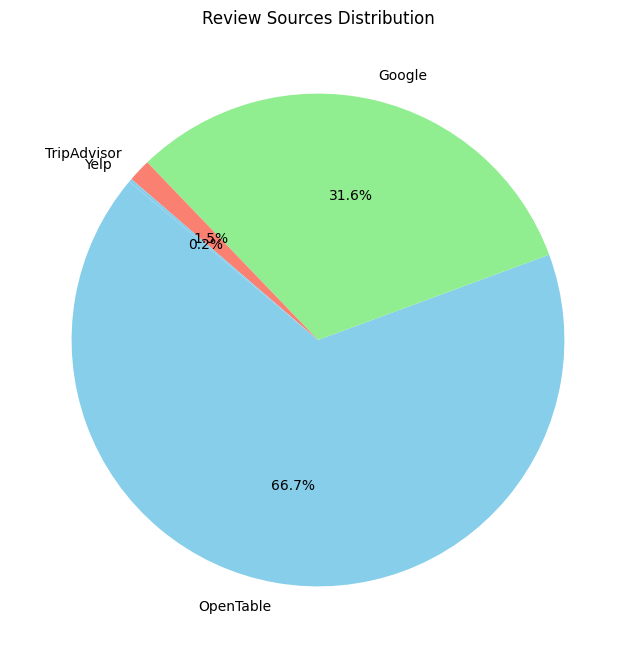

In [ ]:
source_counts = df['source'].value_counts()
# Plotting the pie chart
plt.figure(figsize=(8, 8))  # Set the figure size for better visibility
plt.pie(source_counts, labels=source_counts.index, autopct='%1.1f%%', startangle=140, colors=['skyblue', 'lightgreen', 'salmon'])
plt.title('Review Sources Distribution')
plt.show()


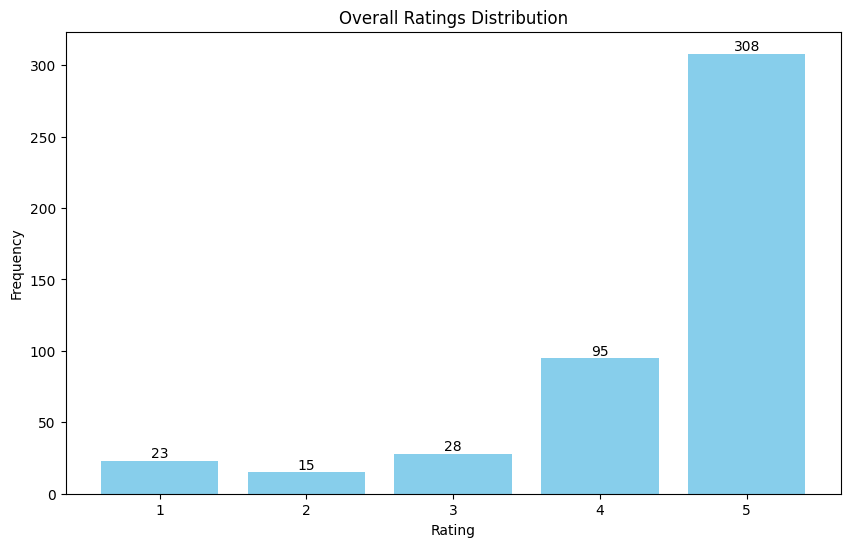

In [ ]:
rating_counts = df['overall_rating'].value_counts().sort_index()

# Set up the figure and axis
plt.figure(figsize=(10, 6))

# Create a bar plot
plt.bar(rating_counts.index, rating_counts.values, color='skyblue')

# Add labels and title
plt.xlabel('Rating')
plt.ylabel('Frequency')
plt.title('Overall Ratings Distribution')

# Optional: Add value labels on top of each bar
for index, value in enumerate(rating_counts.values):
    plt.text(index + 1, value, str(value), ha='center', va='bottom')

# Show the plot
plt.show()

In [ ]:
df['review_date'] = pd.to_datetime(df['review_date'])

# Set the review date as the index
df.set_index('review_date', inplace=True)

# Resample the data by month and count the number of reviews per month
monthly_reviews = df.resample('M').size()

# Calculate the average number of reviews per month
average_reviews_per_month = monthly_reviews.mean()

print(f"The average number of reviews per month is: {average_reviews_per_month}")

The average number of reviews per month is: 36.07692307692308


In [ ]:
def get_reviews_in_month(year, month):
    specific_month_reviews = df.loc[f'{year}-{month:02d}']
    return specific_month_reviews.shape[0]

# Replace with the desired year and month
year = 2024
month = 5

number_of_reviews = get_reviews_in_month(year, month)
print(f"The number of reviews in {year}-{month:02d} is: {number_of_reviews}")

The number of reviews in 2024-05 is: 24


In [ ]:
total_reviews = df.shape[0]

# Calculate the number of reviews with a rating of 1 or 2
low_rating_reviews = df[df['overall_rating'].isin([1, 2])].shape[0]

# Calculate the percentage of reviews with a rating of 1 or 2
percentage_low_ratings = (low_rating_reviews / total_reviews) * 100

print(f"The percentage of reviews with a rating of 1 or 2 is: {percentage_low_ratings:.2f}%")


The percentage of reviews with a rating of 1 or 2 is: 8.10%


In [ ]:
average_rating = df['overall_rating'].mean()

print(f"The average rating over the entire period is: {average_rating:.2f}")

The average rating over the entire period is: 4.39


In [ ]:
def get_average_rating_in_month(year, month):
    specific_month_reviews = df.loc[f'{year}-{month:02d}']
    if specific_month_reviews.empty:
        return None
    return specific_month_reviews['overall_rating'].mean()

# Replace with the desired year and month
year = 2024
month = 5

average_rating = get_average_rating_in_month(year, month)
if average_rating is not None:
    print(f"The average rating in {year}-{month:02d} is: {average_rating:.2f}")
else:
    print(f"No reviews found for {year}-{month:02d}")

The average rating in 2024-05 is: 4.58


In [ ]:
average_ratings = df[["food","service","ambience"]].mean()


In [ ]:
total_values = len(df_classified_ner['response'])

# Calculate the number of non-NA values in the column
non_na_values = total_values - df_classified_ner['response'].isnull().sum()

# Calculate the percentage of non-NA values
percentage_non_na = (non_na_values / total_values) * 100

print(f"The percentage of non-NA values in the column is: {percentage_non_na:.2f}%")

The percentage of non-NA values in the column is: 6.45%


In [ ]:
df_classified_ner['review_date'] = pd.to_datetime(df_classified_ner['review_date'])

# Set the review date as the index
df_classified_ner.set_index('review_date', inplace=True)

# Function to get the percentage of non-NA values in a specific month and year
def get_percentage_non_na_in_month(year, month, column_name):
    specific_month_reviews = df_classified_ner.loc[f'{year}-{month:02d}']
    total_values = len(specific_month_reviews[column_name])
    non_na_values = total_values - specific_month_reviews[column_name].isnull().sum()
    if total_values == 0:
        return 0
    percentage_non_na = (non_na_values / total_values) * 100
    return percentage_non_na

# Replace with the desired year, month, and column name
year = 2024
month = 5
column_name = 'response'

percentage_non_na = get_percentage_non_na_in_month(year, month, column_name)
print(f"The percentage of non-NA values in {column_name} for {year}-{month:02d} is: {percentage_non_na:.2f}%")

The percentage of non-NA values in response for 2024-05 is: 9.09%


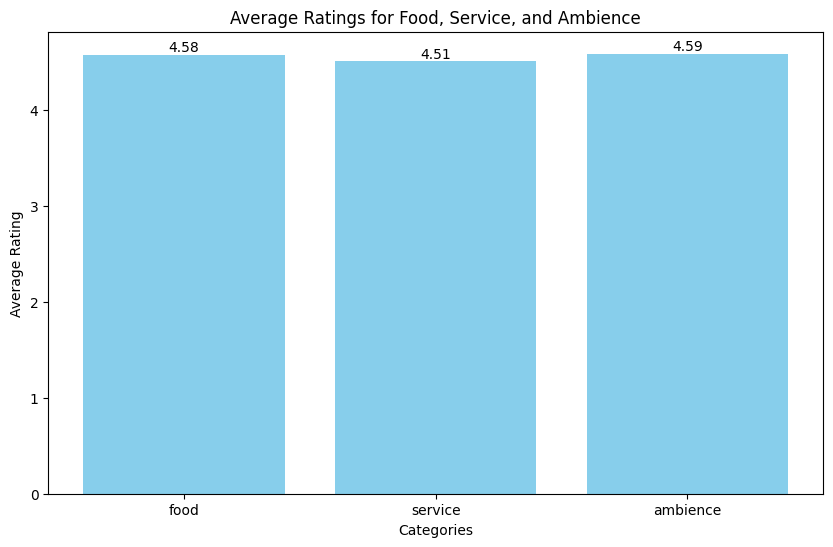

In [ ]:
plt.figure(figsize=(10, 6))

# Create a bar plot
plt.bar(average_ratings.index, average_ratings.values, color='skyblue')

# Add labels and title
plt.xlabel('Categories')
plt.ylabel('Average Rating')
plt.title('Average Ratings for Food, Service, and Ambience')

# Optional: Add value labels on top of each bar
for index, value in enumerate(average_ratings.values):
    plt.text(index, value, f'{value:.2f}', ha='center', va='bottom')

# Show the plot
plt.show()

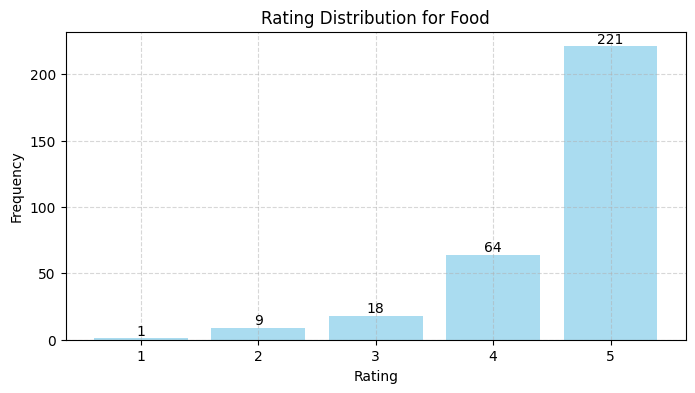

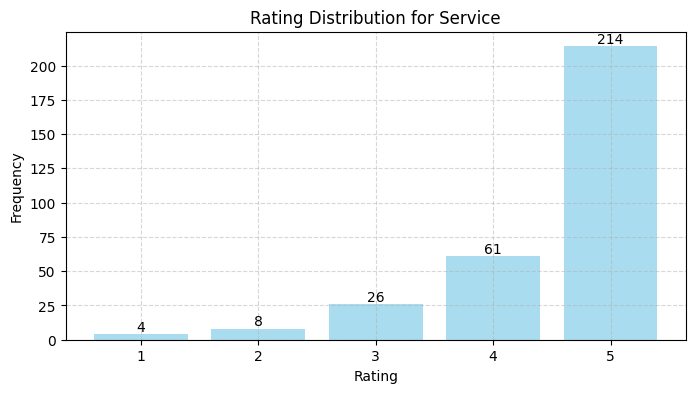

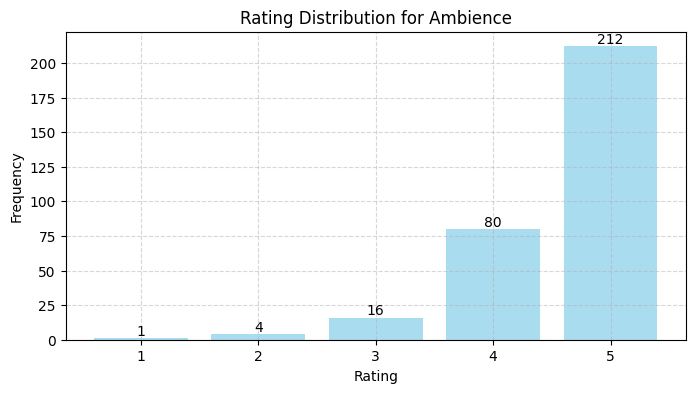

In [ ]:
# Function to plot each category
def plot_category_ratings(data, category):
    plt.figure(figsize=(8, 4))
    rating_counts = data[category].value_counts().sort_index()

    # Bar plot for the category
    plt.bar(rating_counts.index, rating_counts.values, color='skyblue', alpha=0.7)

    # Adding labels and title
    plt.xlabel('Rating')
    plt.ylabel('Frequency')
    plt.title(f'Rating Distribution for {category.capitalize()}')

    # Show value labels
    for index, value in zip(rating_counts.index, rating_counts.values):
        plt.text(index, value, str(value), ha='center', va='bottom')

    plt.xticks(rating_counts.index)  # Ensure only existing ratings are shown
    plt.grid(True, linestyle='--', alpha=0.5)
    plt.show()

# Plot each subcategory
for category in ['food', 'service', 'ambience']:
    plot_category_ratings(df, category)


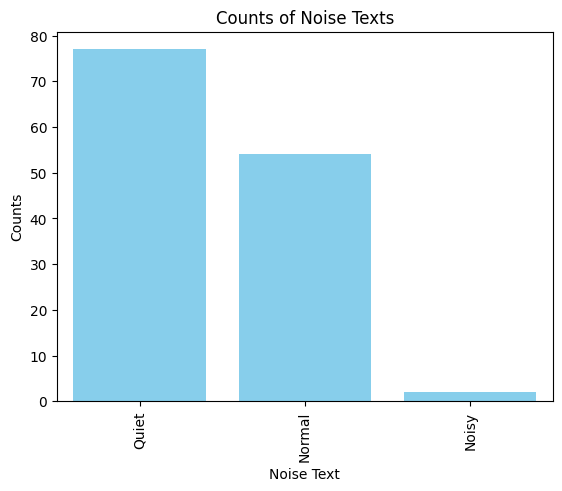

In [ ]:
counts = df['noise_text'].value_counts()

# Plot the counts
counts.plot(kind='bar', color=['blue', 'green', 'red'])
plt.bar(counts.index, counts.values, color='skyblue')

# Add titles and labels
plt.title('Counts of Noise Texts')
plt.xlabel('Noise Text')
plt.ylabel('Counts')

# Show the plot
plt.show()

## Numerische Analyse von Reviews mit Text

In [ ]:
file_path = '/content/drive/My Drive/Barshuka/df_classified_ner.csv'
df_classified_ner = pd.read_csv(file_path)

In [ ]:
df_classified_ner.shape

(217, 28)

In [ ]:
from ast import literal_eval


In [ ]:
df_classified_ner["labels"] = df_classified_ner["labels"].apply(lambda x: list(literal_eval(x)))


In [ ]:
from collections import Counter

# Assuming df_plots["labels"] contains lists of labels
all_labels = [label for sublist in df_classified_ner["labels"] for label in sublist]

# Count the occurrences of each label
label_counts = Counter(all_labels)
label_counts


Counter({'Essen': 138,
         'Hygiene': 15,
         'Service': 109,
         'Ambiente': 56,
         'Speisekarte': 20,
         'Preis': 44,
         'Getränke': 14})

In [ ]:
df_exploded = df_classified_ner.explode('labels')

# Prepare your data: aggregate by Label and Rating, then count occurrences
df_aggregated = df_exploded.groupby(['labels', 'overall_rating']).size().reset_index(name='Count')

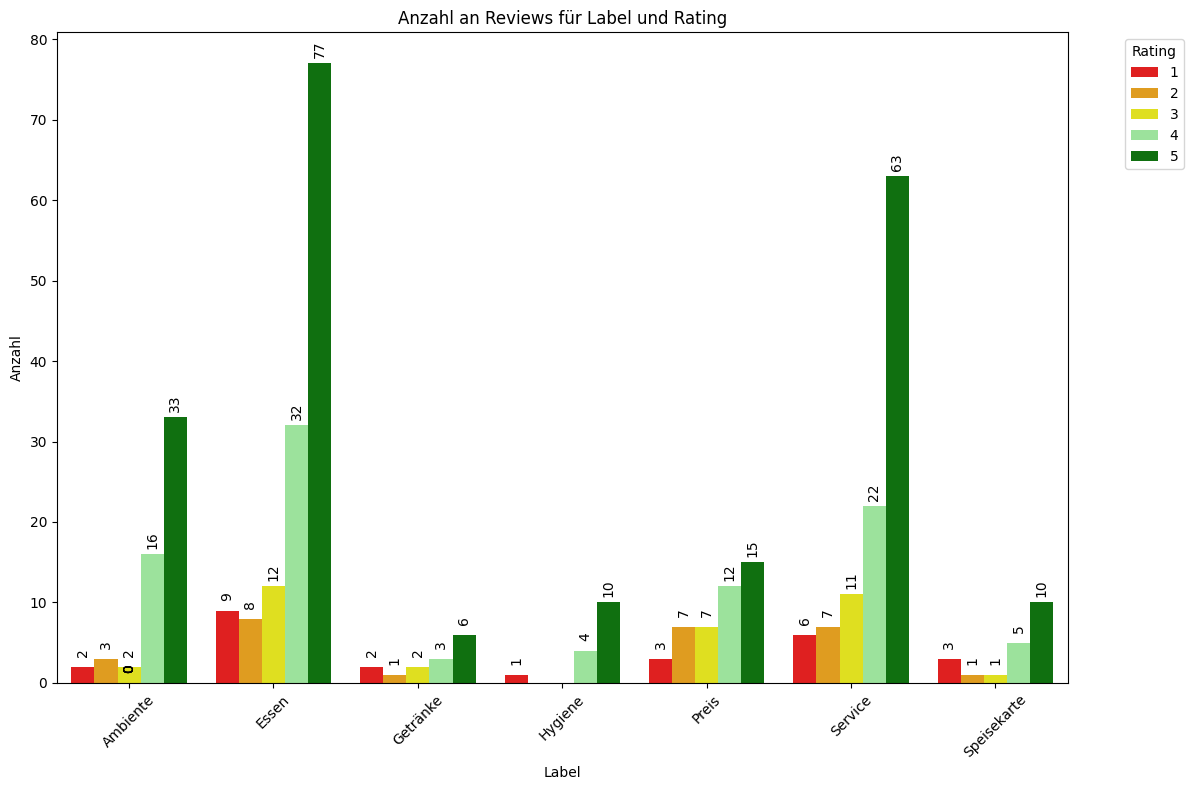

In [ ]:
from matplotlib.colors import LinearSegmentedColormap

# Assuming df_exploded and df_aggregated are already defined as per your previous messages

# Define a red to green color map
colors = ["red", "orange", "yellow", "lightgreen", "green"]
cmap_name = 'rating_cmap'
n_bins = 5  # Assuming ratings go from 1 to 5
rating_cmap = LinearSegmentedColormap.from_list(cmap_name, colors, N=n_bins)

# Plot
plt.figure(figsize=(12, 8))
ax = sns.barplot(data=df_aggregated, x='labels', y='Count', hue='overall_rating', palette=rating_cmap)

# Rotate x-labels
plt.xticks(rotation=45)

# Add counts above the bars
for p in ax.patches:
    height = p.get_height()
    ax.annotate(f'{int(height)}',
                (p.get_x() + p.get_width() / 2., height),
                ha='center',
                va='center',
                xytext=(0, 10),  # Increase the space between the bar and the number
                textcoords='offset points',
                rotation=90)

plt.title('Anzahl an Reviews für Label und Rating')
plt.xlabel('Label')
plt.ylabel('Anzahl')
plt.legend(title='Rating', bbox_to_anchor=(1.05, 1), loc='upper left')

plt.tight_layout()
plt.show()

In [ ]:
total_counts = df_exploded['labels'].value_counts()

# Step 2: Calculate bad counts for each label
bad_ratings = df_exploded[df_exploded['overall_rating'].isin([1, 2])]
bad_counts = bad_ratings['labels'].value_counts()

# Step 3: Calculate the percentage of bad counts out of total counts
bad_percentage = (bad_counts / total_counts) * 100


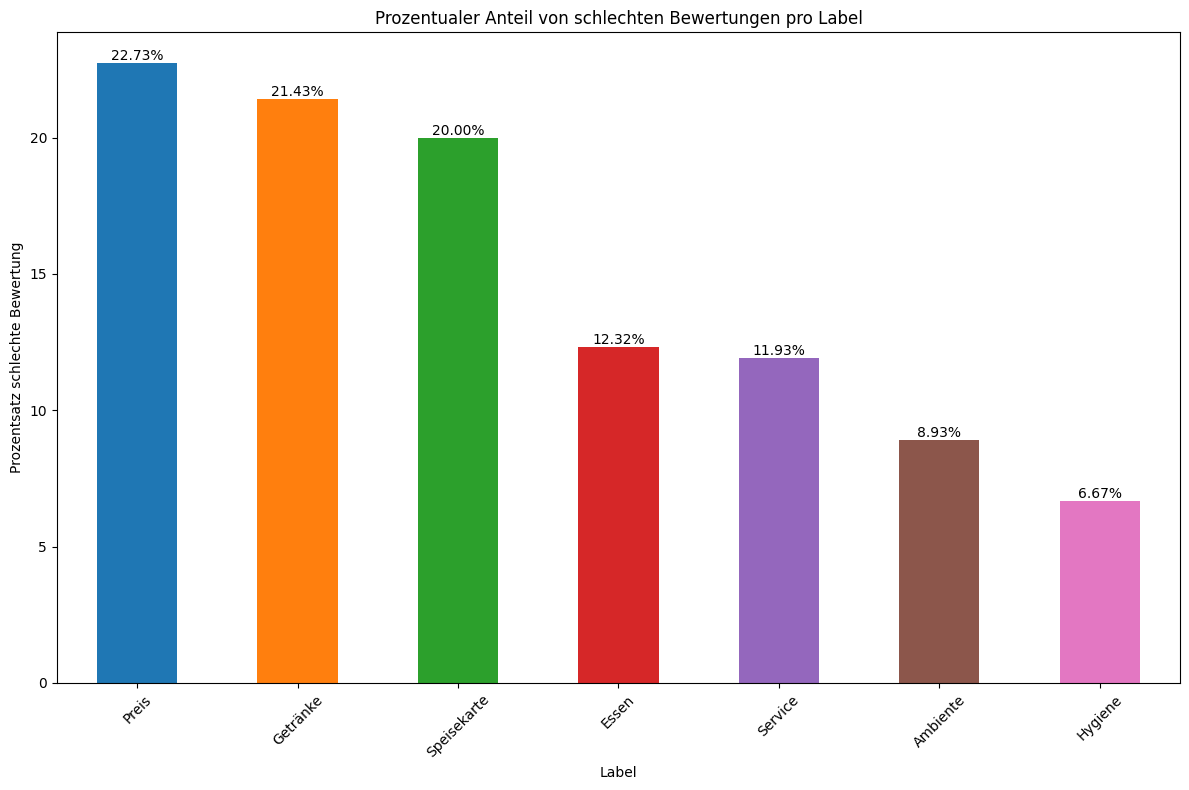

In [ ]:
import matplotlib.colors as mcolors

bad_percentage_sorted = bad_percentage.sort_values(ascending=False)

# Generate a list of unique colors
colors = list(mcolors.TABLEAU_COLORS)  # This generates a list of unique color names
if len(bad_percentage_sorted) > len(colors):  # If there are more labels than colors, we extend the list
    colors.extend(mcolors.CSS4_COLORS)

# Ensure we have a unique color for each label
unique_colors = colors[:len(bad_percentage_sorted)]

# Visualize with unique colors
plt.figure(figsize=(12, 8))
bad_percentage_sorted.plot(kind='bar', color=unique_colors)

# Adjusting the x-labels
plt.xticks(rotation=45)

# Adding percentage labels above each bar
for index, value in enumerate(bad_percentage_sorted):
    plt.text(index, value, f'{value:.2f}%', ha='center', va='bottom')

plt.title('Prozentualer Anteil von schlechten Bewertungen pro Label')
plt.xlabel('Label')
plt.ylabel('Prozentsatz schlechte Bewertung')

ax.set_facecolor('none')

plt.tight_layout()
plt.show()


In [ ]:
df_exploded['review_date'] = pd.to_datetime(df_exploded['review_date'], errors='coerce')

# Verify if there are any NaT (Not a Time) values which indicate failed conversions
print(df_exploded['review_date'].isnull().sum())

# Extract year and month from the date
df_exploded['year_month'] = df_exploded['review_date'].dt.to_period('M')

0


In [ ]:
def parse_dates(date_str):
    for fmt in ('%d.%m.%Y', '%d.%m.%y', '%Y-%m-%d'):  # Add or adjust formats as needed
        try:
            return pd.to_datetime(date_str, format=fmt)
        except ValueError:
            continue
    return pd.NaT  # return Not a Time for unparseable formats

# Apply the function to the review_date column
df_exploded['review_date'] = df_exploded['review_date'].apply(parse_dates)

# Check for any NaT values again
print(df_exploded['review_date'].isnull().sum())

0


In [ ]:
monthly_label_counts = df_exploded.groupby(['year_month', 'labels']).size().unstack(fill_value=0)
monthly_label_counts.index = monthly_label_counts.index.to_timestamp()

In [ ]:
# Filter the data to include only the desired date range
start_date = pd.to_datetime('2018-01-01')
end_date = pd.to_datetime('2024-06-24')  # Replace 2022 with the latest year if necessary

filtered_data = monthly_label_counts[(monthly_label_counts.index >= start_date) & (monthly_label_counts.index <= end_date)]


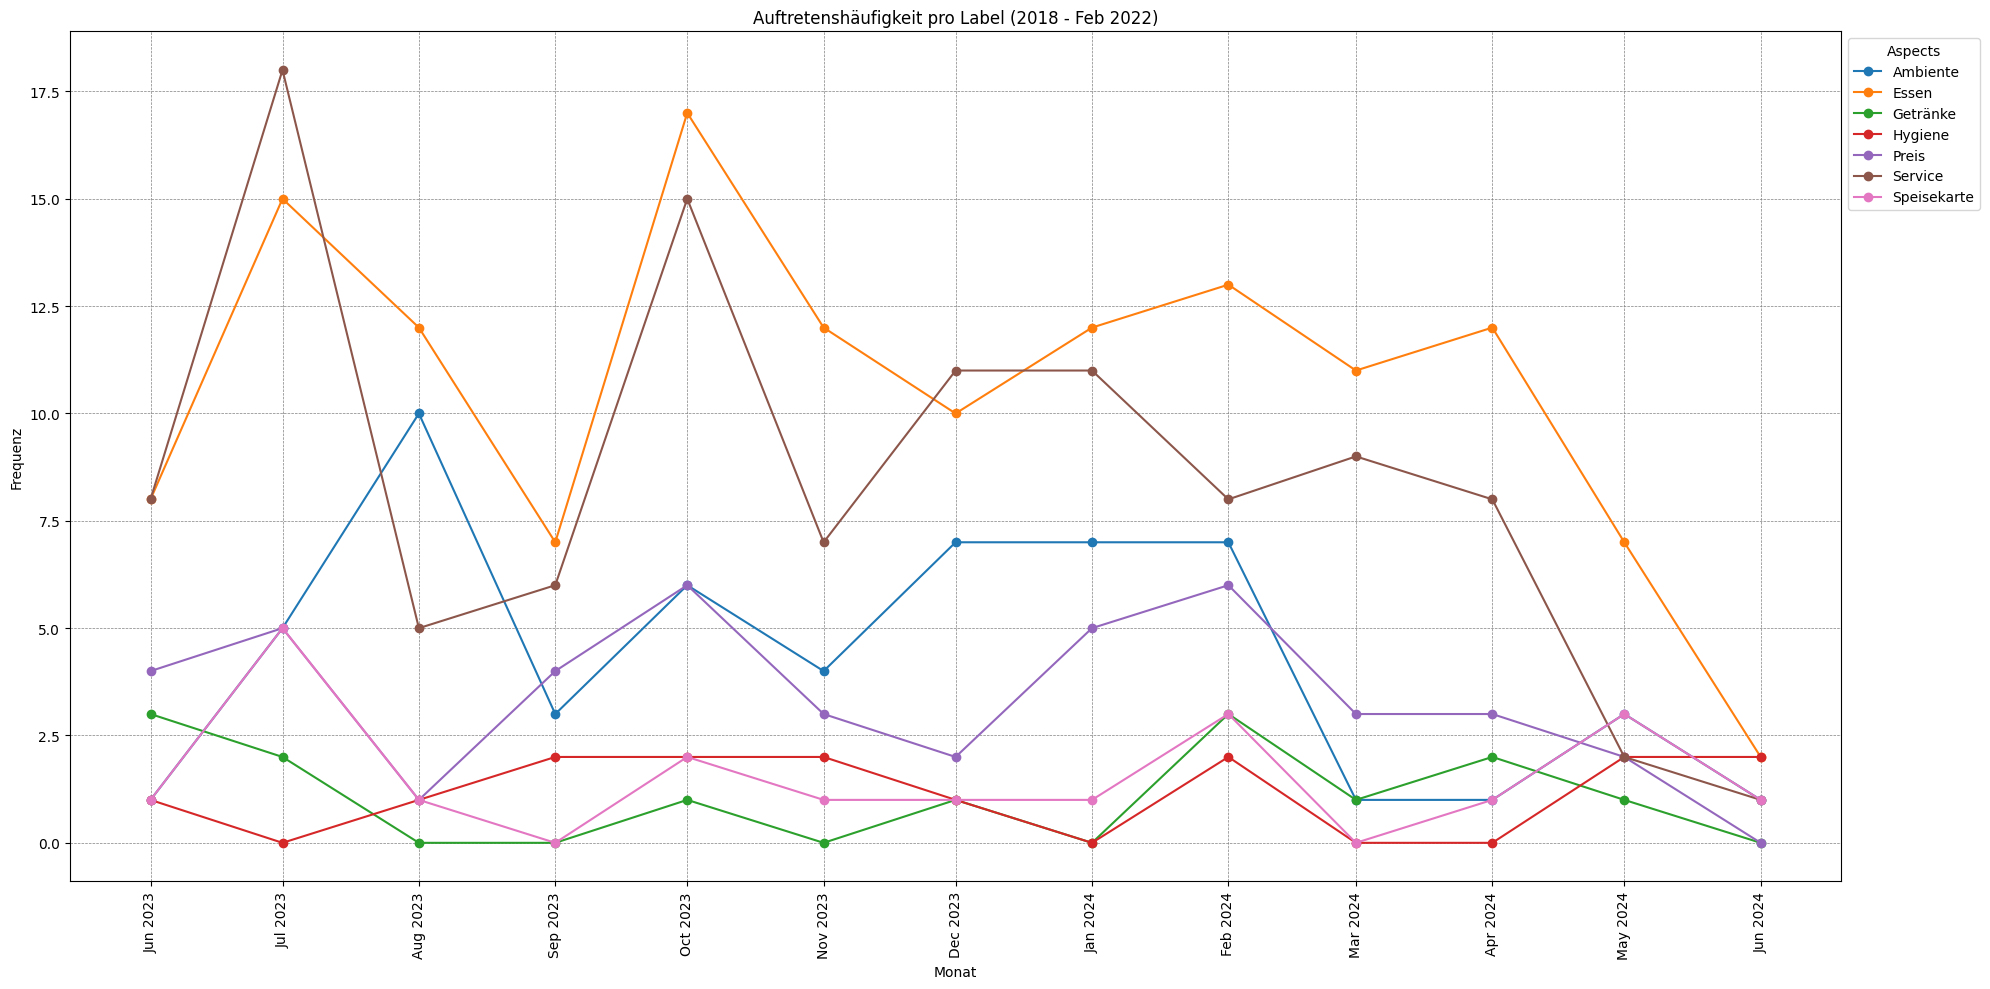

In [ ]:
import matplotlib.dates as mdates

# Increase figure size for better readability
plt.figure(figsize=(20, 10))

# Plot a line for each label with a consistent marker style
for label in filtered_data.columns:
    plt.plot(filtered_data.index, filtered_data[label], marker='o', linestyle='-', label=label)

# Enhance plot
plt.title('Auftretenshäufigkeit pro Label (2018 - Feb 2022)')
plt.xlabel('Monat')
plt.ylabel('Frequenz')

# Position the legend outside the plot area
plt.legend(title='Aspects', loc='upper left', bbox_to_anchor=(1, 1))

# Set grid lines to be less obtrusive
plt.grid(True, linestyle='--', linewidth=0.5, color='gray')

# Rotate the x-axis dates by 90 degrees for better readability
plt.xticks(rotation=90)

# Format the x-axis to show dates in a more readable format and thin out the ticks
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%b %Y'))
plt.gca().xaxis.set_major_locator(mdates.MonthLocator(interval=1))

# Show plot
plt.tight_layout()
plt.show()



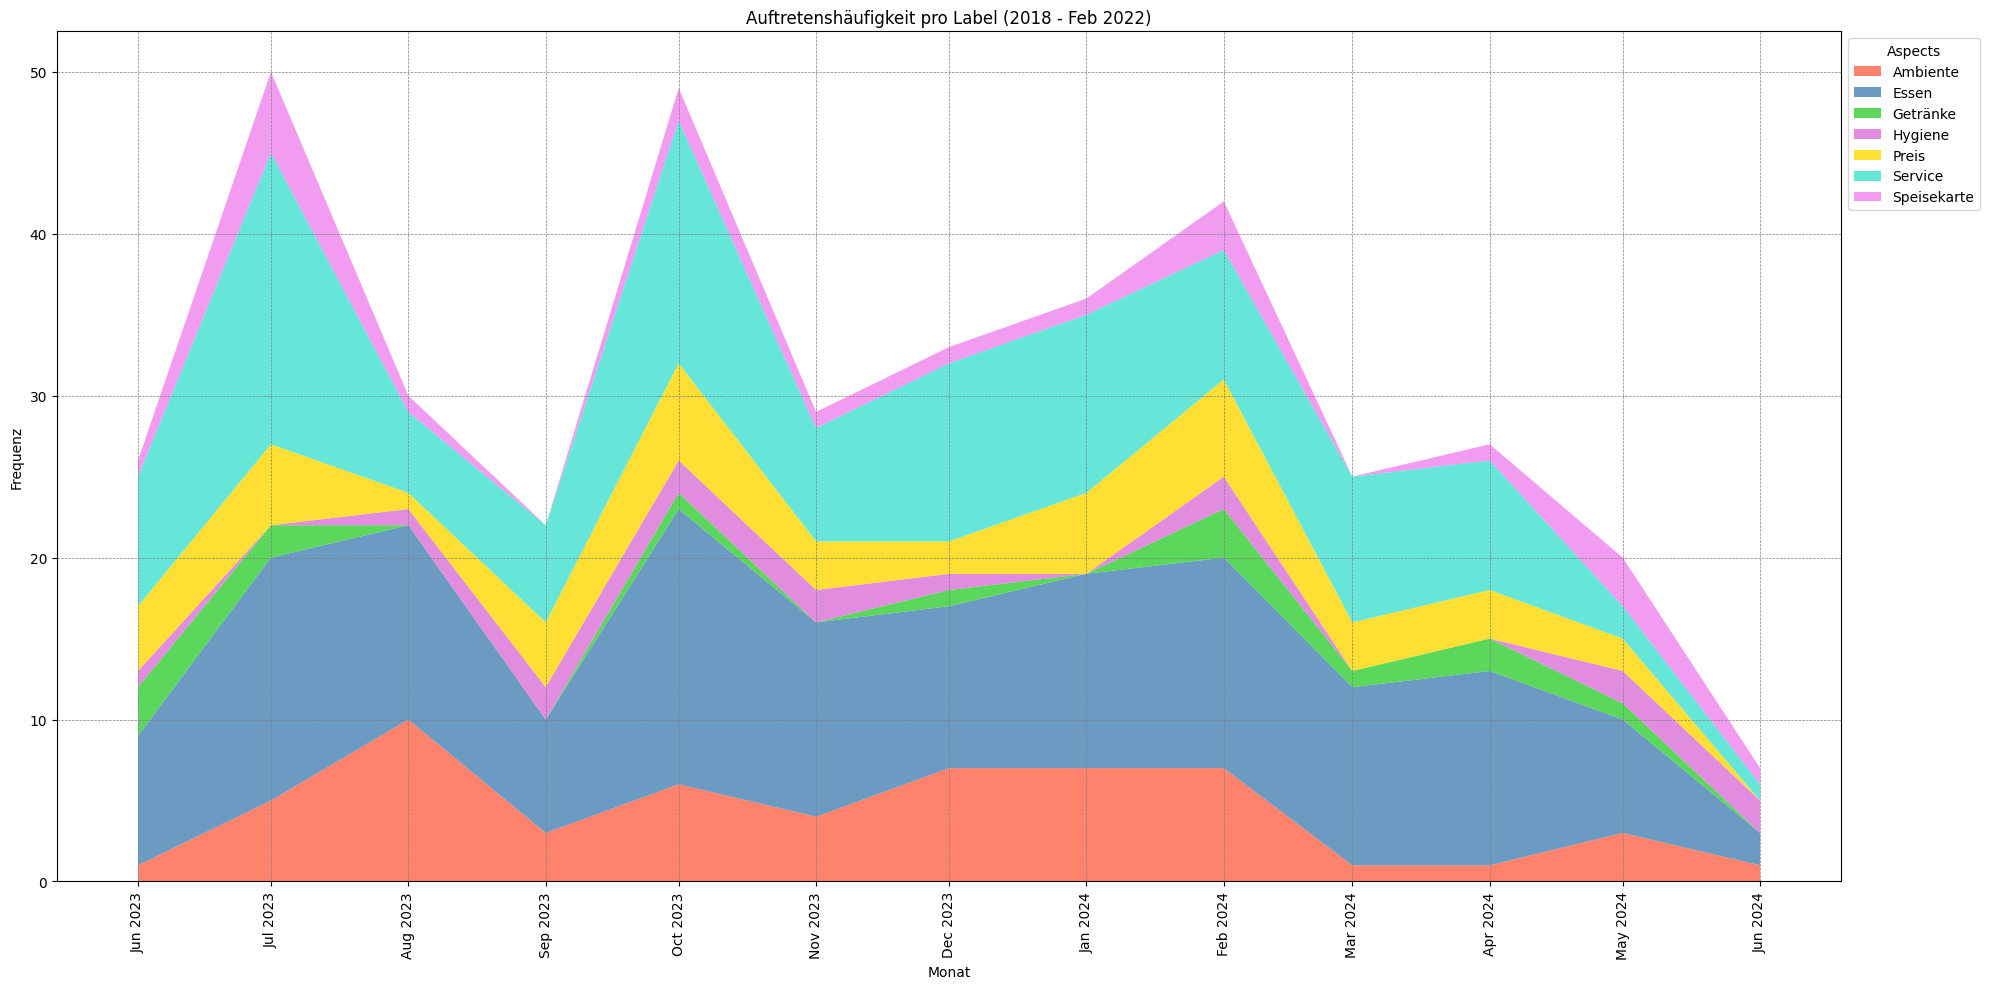

In [ ]:
plt.figure(figsize=(20, 10))

# Create a list of colors if you have specific colors in mind or use a colormap
colors = ['#FF6347', '#4682B4', '#32CD32', '#DA70D6', '#FFD700', '#40E0D0', '#EE82EE', '#8A2BE2', '#A52A2A', '#DEB887']

# Plot the stacked area chart
plt.stackplot(filtered_data.index, [filtered_data[label] for label in filtered_data.columns], labels=filtered_data.columns, colors=colors, alpha=0.8)

# Enhance plot
plt.title('Auftretenshäufigkeit pro Label (2018 - Feb 2022)')
plt.xlabel('Monat')
plt.ylabel('Frequenz')

# Position the legend outside the plot area
plt.legend(title='Aspects', loc='upper left', bbox_to_anchor=(1, 1))

# Set grid lines to be less obtrusive
plt.grid(True, linestyle='--', linewidth=0.5, color='gray')

# Rotate the x-axis dates for better readability
plt.xticks(rotation=90)

# Format the x-axis to show dates in a more readable format and thin out the ticks
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%b %Y'))
plt.gca().xaxis.set_major_locator(mdates.MonthLocator(interval=1))

# Show plot
plt.tight_layout()
plt.show()

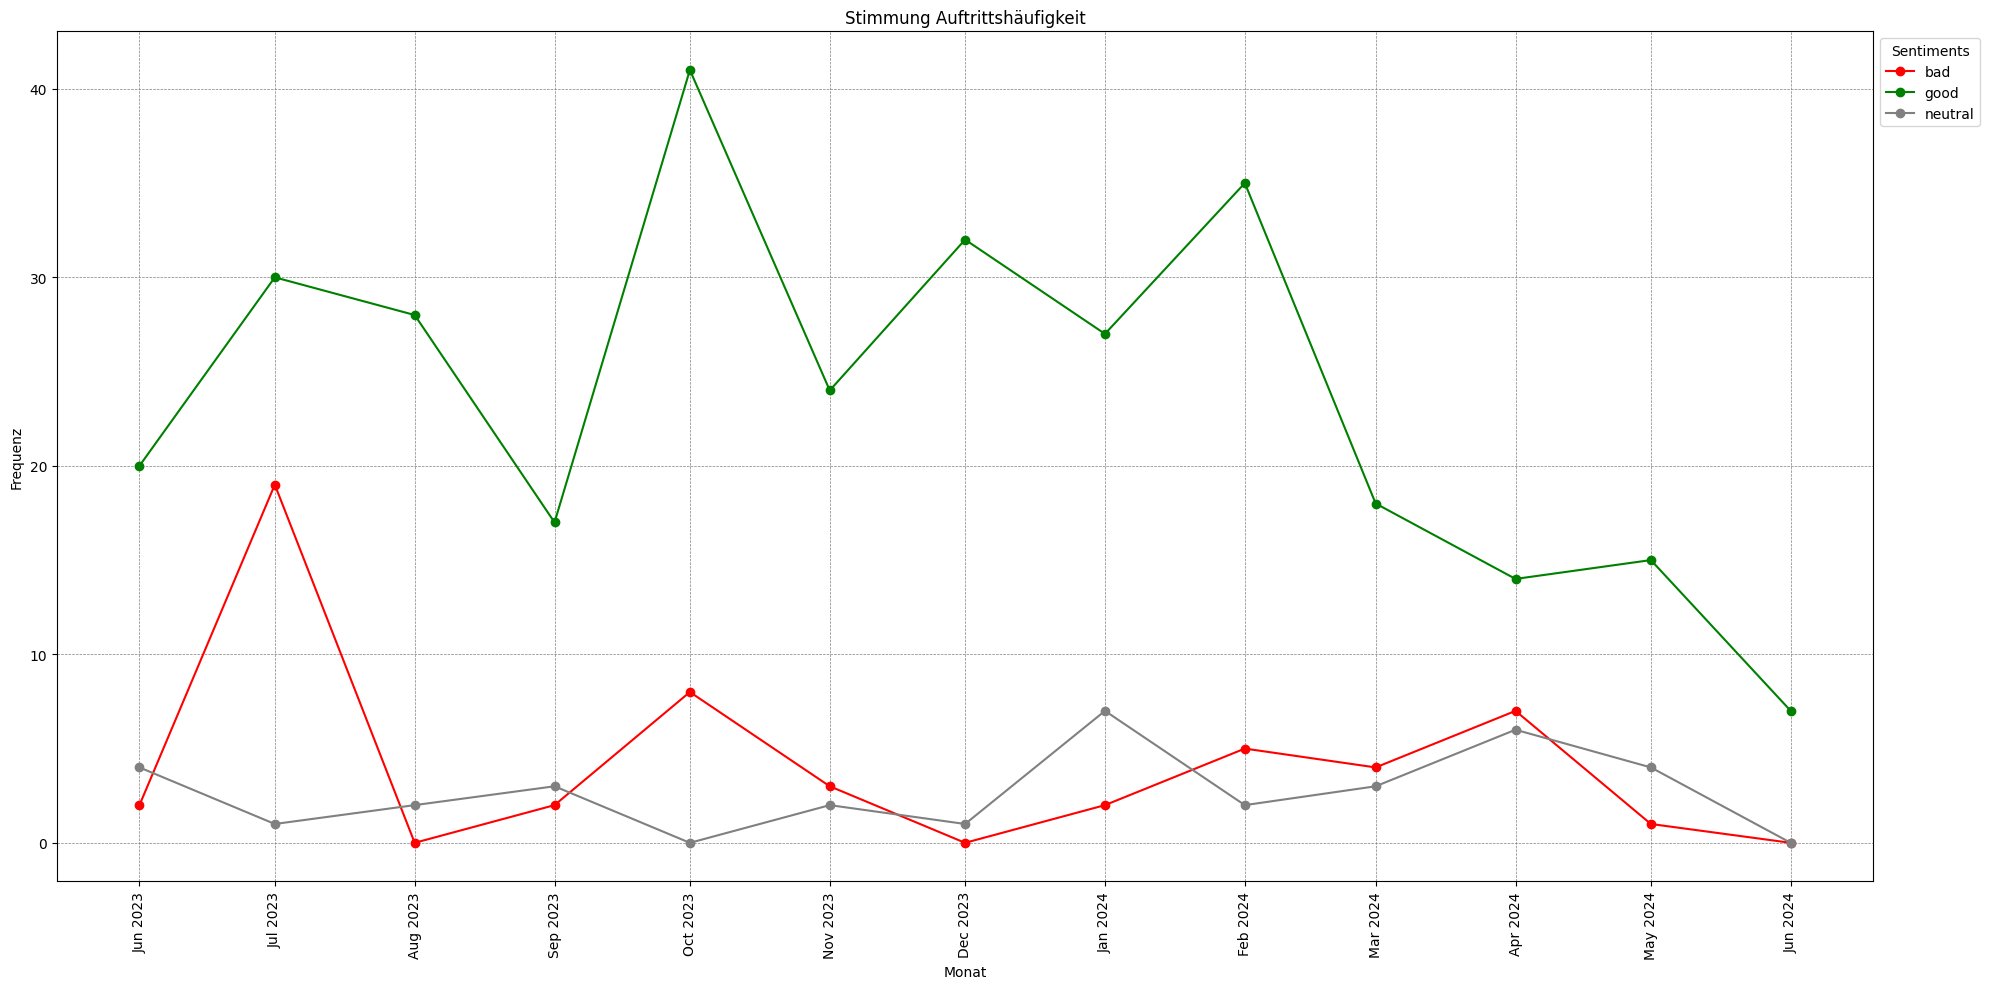

In [ ]:
# First, categorize the review ratings into sentiments
def categorize_sentiment(rating):
    if rating in [1, 2]:
        return 'bad'
    elif rating == 3:
        return 'neutral'
    else:  # for ratings 4 and 5
        return 'good'

# Apply the categorization function to the review ratings
df_exploded['sentiment'] = df_exploded['overall_rating'].apply(categorize_sentiment)

# Filter the data for the desired date range as previously described
start_date = pd.to_datetime('2020-01-01')
end_date = pd.to_datetime('2024-06-24')  # Adjust the end year as needed

# Now group by year_month and sentiment, and count the occurrences
monthly_sentiment_counts = df_exploded[(df_exploded['review_date'] >= start_date) &
                                       (df_exploded['review_date'] <= end_date)].groupby(['year_month', 'sentiment']).size().unstack(fill_value=0)

# Convert the PeriodIndex to a DateTimeIndex for plotting
monthly_sentiment_counts.index = monthly_sentiment_counts.index.to_timestamp()

# Increase figure size for better readability
plt.figure(figsize=(20, 10))

# Define colors for sentiments
colors = {'bad': 'red', 'neutral': 'grey', 'good': 'green'}

# Plot a line for each sentiment category with the specified color
for sentiment in monthly_sentiment_counts.columns:
    plt.plot(monthly_sentiment_counts.index, monthly_sentiment_counts[sentiment],
             marker='o', linestyle='-', label=sentiment, color=colors[sentiment])

# Enhance plot
plt.title('Stimmung Auftrittshäufigkeit')
plt.xlabel('Monat')
plt.ylabel('Frequenz')

# Position the legend outside the plot area
plt.legend(title='Sentiments', loc='upper left', bbox_to_anchor=(1, 1))

# Set grid lines to be less obtrusive
plt.grid(True, linestyle='--', linewidth=0.5, color='gray')

# Rotate the x-axis dates by 90 degrees for better readability
plt.xticks(rotation=90)

# Format the x-axis to show dates in a more readable format and thin out the ticks
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%b %Y'))
plt.gca().xaxis.set_major_locator(mdates.MonthLocator(interval=1))

# Show plot
plt.tight_layout()
plt.show()

In [ ]:
# Apply the sentiment categorization function to the review ratings
df_exploded['sentiment'] = df_exploded['overall_rating'].apply(categorize_sentiment)

# Filter the DataFrame for the desired date range
df_filtered = df_exploded[(df_exploded['review_date'] >= start_date) & (df_exploded['review_date'] <= end_date)]

# Explode the DataFrame on the 'labels' column so each label gets its own row
df_exploded_filtered = df_filtered.explode('labels')

# Group by year_month, labels, and sentiment, and count the occurrences
monthly_label_sentiment_counts = df_exploded_filtered.groupby(['year_month', 'labels', 'sentiment']).size().reset_index(name='count')

# Now pivot the table to have sentiments as columns
pivot_df = monthly_label_sentiment_counts.pivot_table(index=['year_month', 'labels'], columns='sentiment', values='count', fill_value=0).reset_index()

# Convert the PeriodIndex to a DateTimeIndex for plotting
pivot_df['year_month'] = pivot_df['year_month'].dt.to_timestamp()

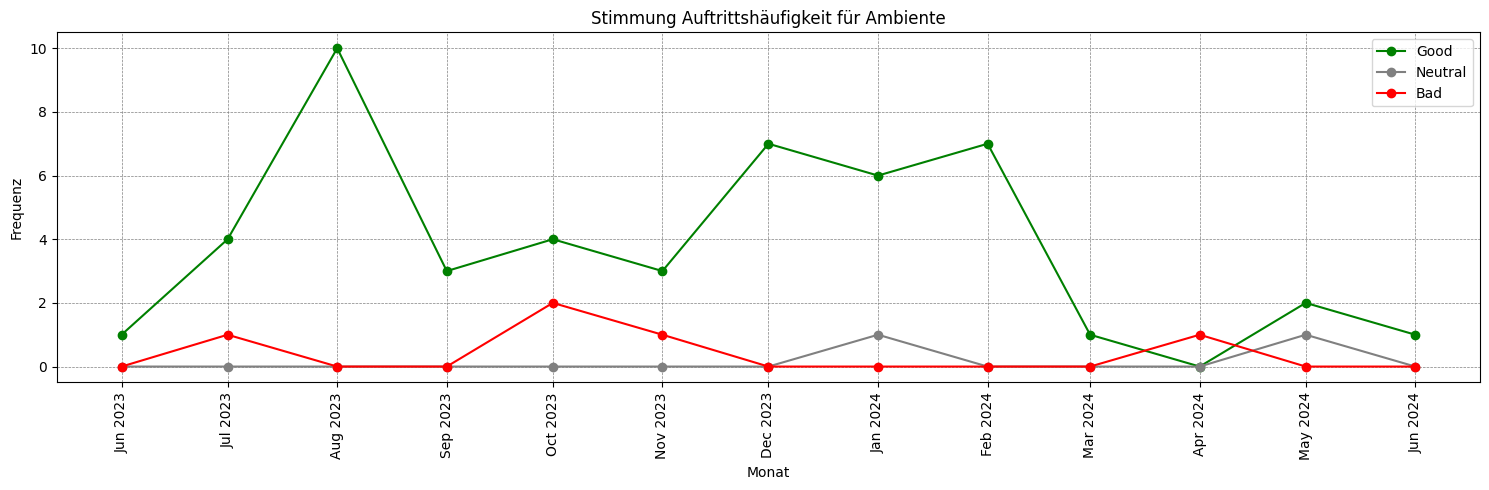

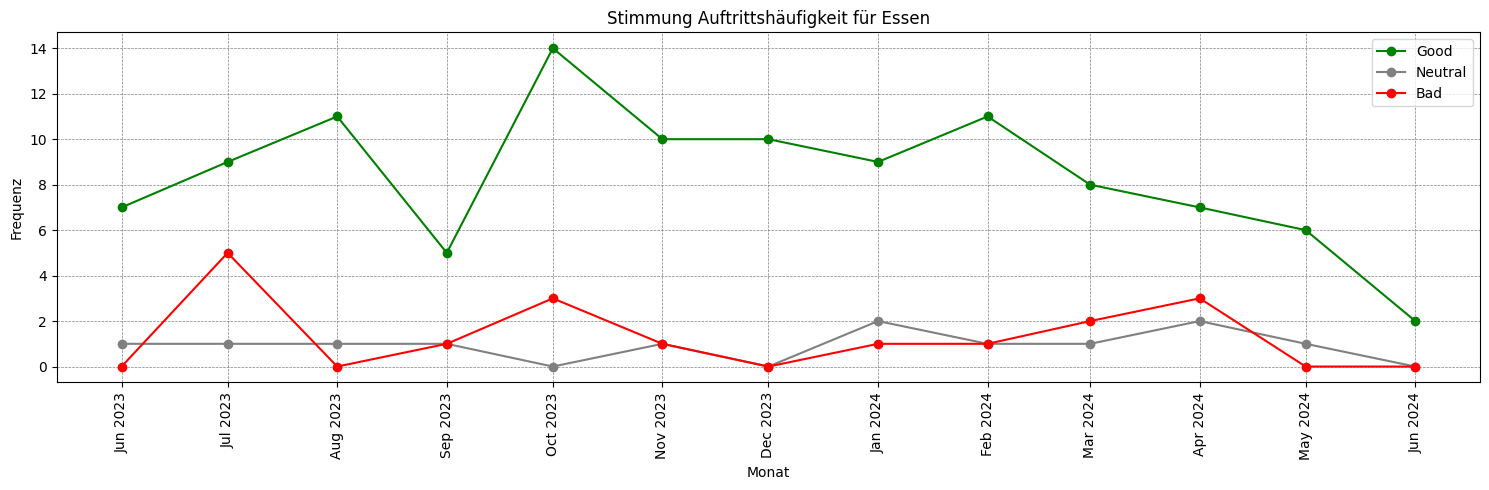

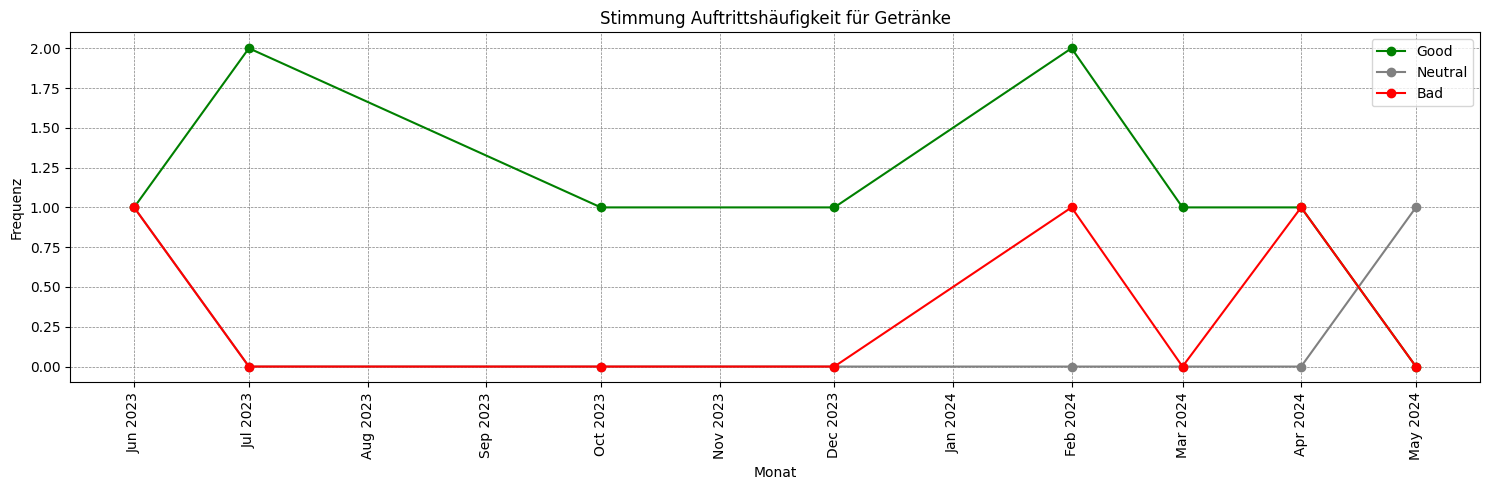

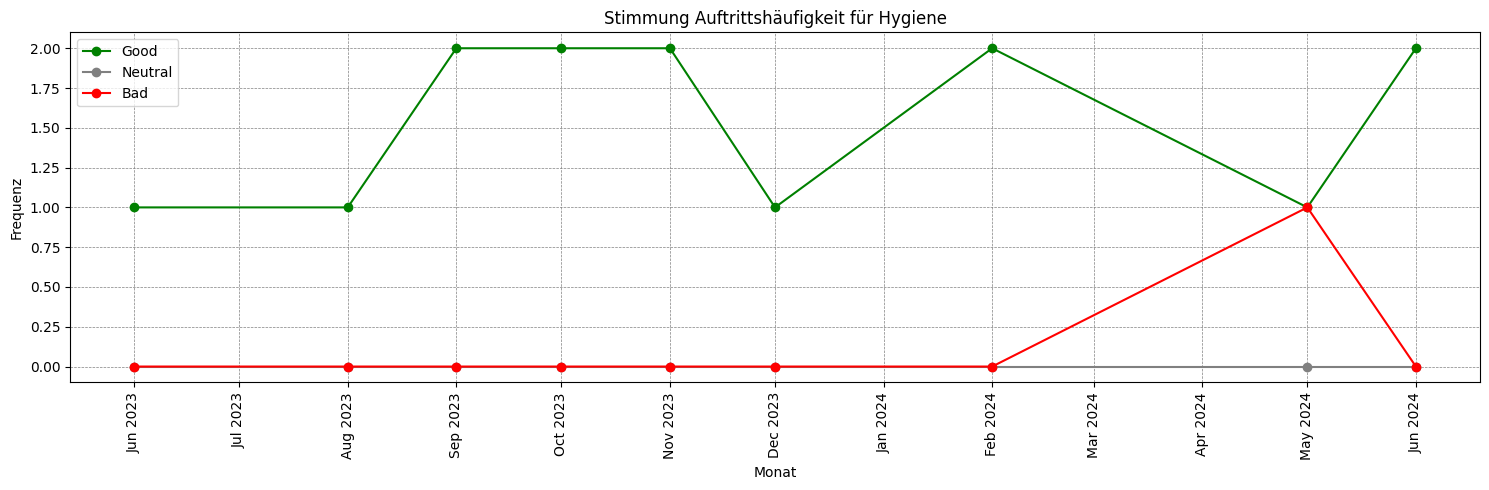

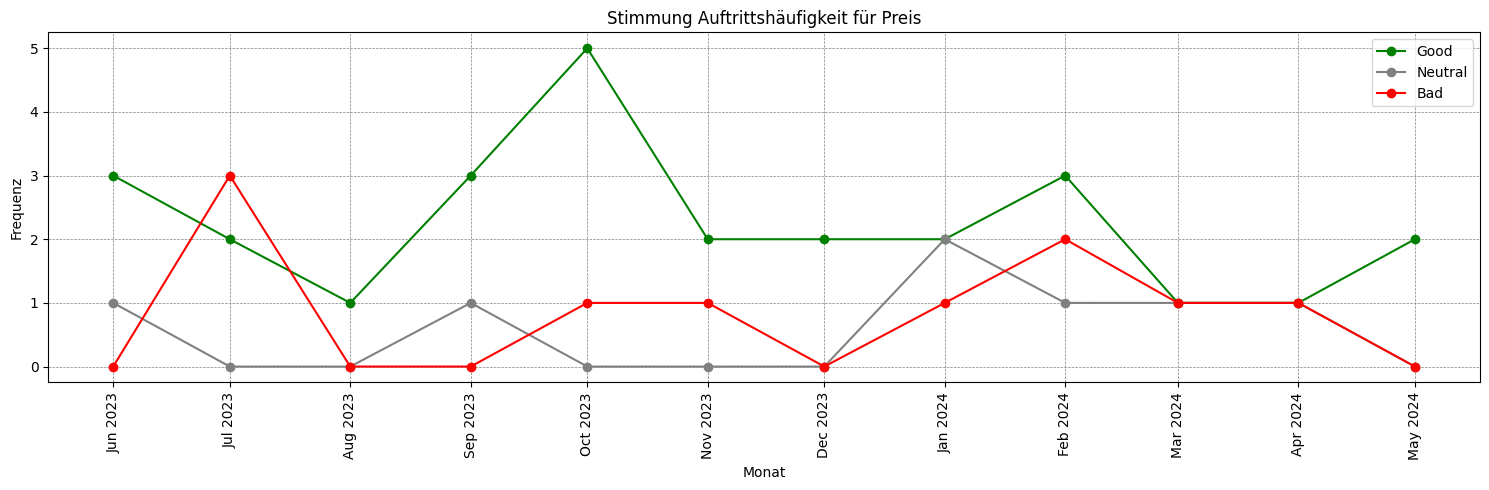

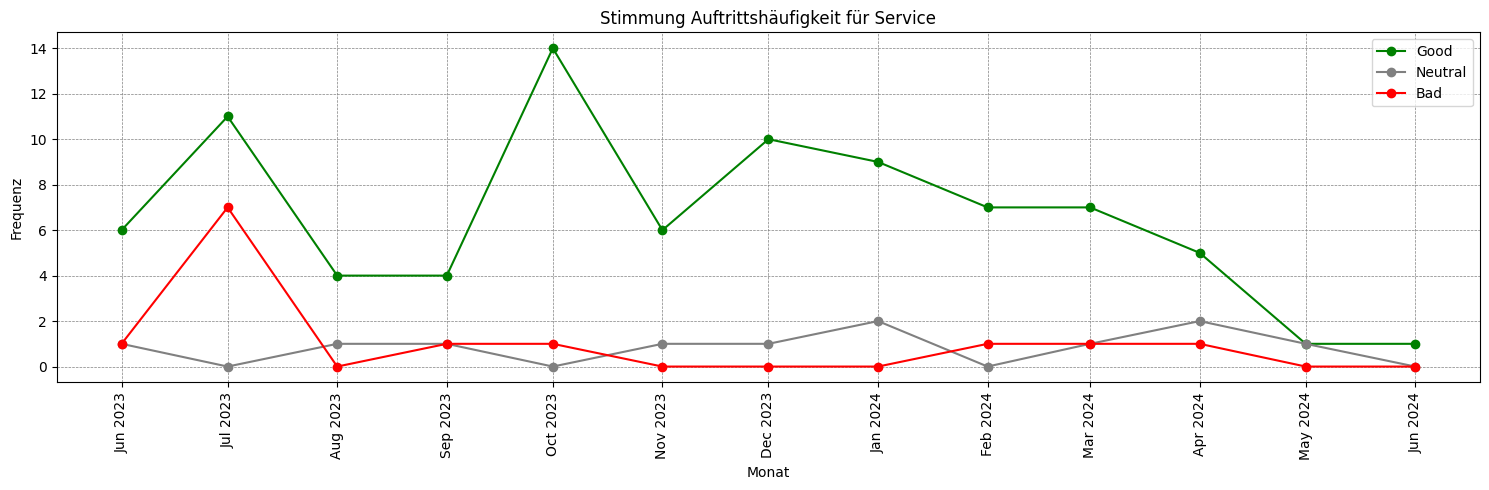

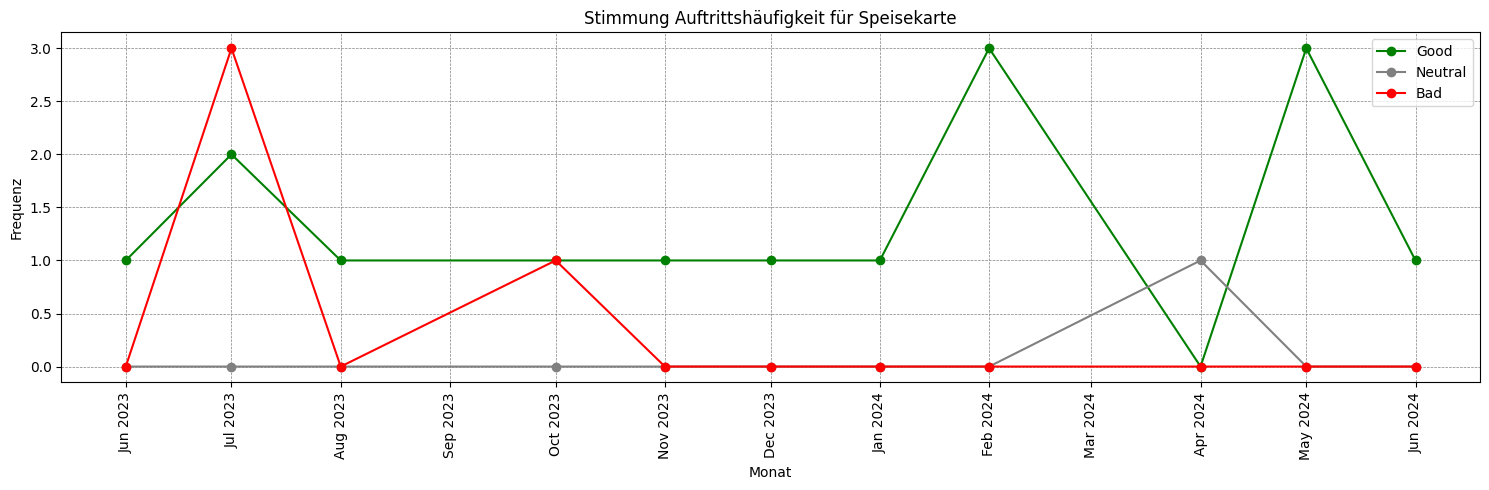

In [ ]:

# Create a separate plot for each label
for label in pivot_df['labels'].unique():
    # Filter the data for the current label
    label_data = pivot_df[pivot_df['labels'] == label]

    # Start a new plot
    plt.figure(figsize=(15, 5))

    # Plot each sentiment category with the specified color
    plt.plot(label_data['year_month'], label_data['good'], color='green', marker='o', linestyle='-', label='Good')
    plt.plot(label_data['year_month'], label_data['neutral'], color='grey', marker='o', linestyle='-', label='Neutral')
    plt.plot(label_data['year_month'], label_data['bad'], color='red', marker='o', linestyle='-', label='Bad')

    # Enhance plot
    plt.title(f'Stimmung Auftrittshäufigkeit für {label}')
    plt.xlabel('Monat')
    plt.ylabel('Frequenz')
    plt.legend()

    # Set grid lines to be less obtrusive
    plt.grid(True, linestyle='--', linewidth=0.5, color='gray')

    # Rotate the x-axis dates by 90 degrees for better readability
    plt.xticks(rotation=90)

    # Format the x-axis to show dates in a more readable format and thin out the ticks
    plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%b %Y'))
    plt.gca().xaxis.set_major_locator(mdates.MonthLocator(interval=1))

    # Show plot
    plt.tight_layout()
    plt.show()

In [ ]:
# Calculate the percentage of each sentiment for each label
sentiment_counts = df_exploded.groupby(['labels', 'sentiment']).size().unstack(fill_value=0)
sentiment_percentages = sentiment_counts.divide(sentiment_counts.sum(axis=1), axis=0) * 100

# Sort the labels by the 'bad' sentiment percentage for a similar look to your example
sorted_labels = sentiment_percentages.sort_values(by='bad', ascending=False).index

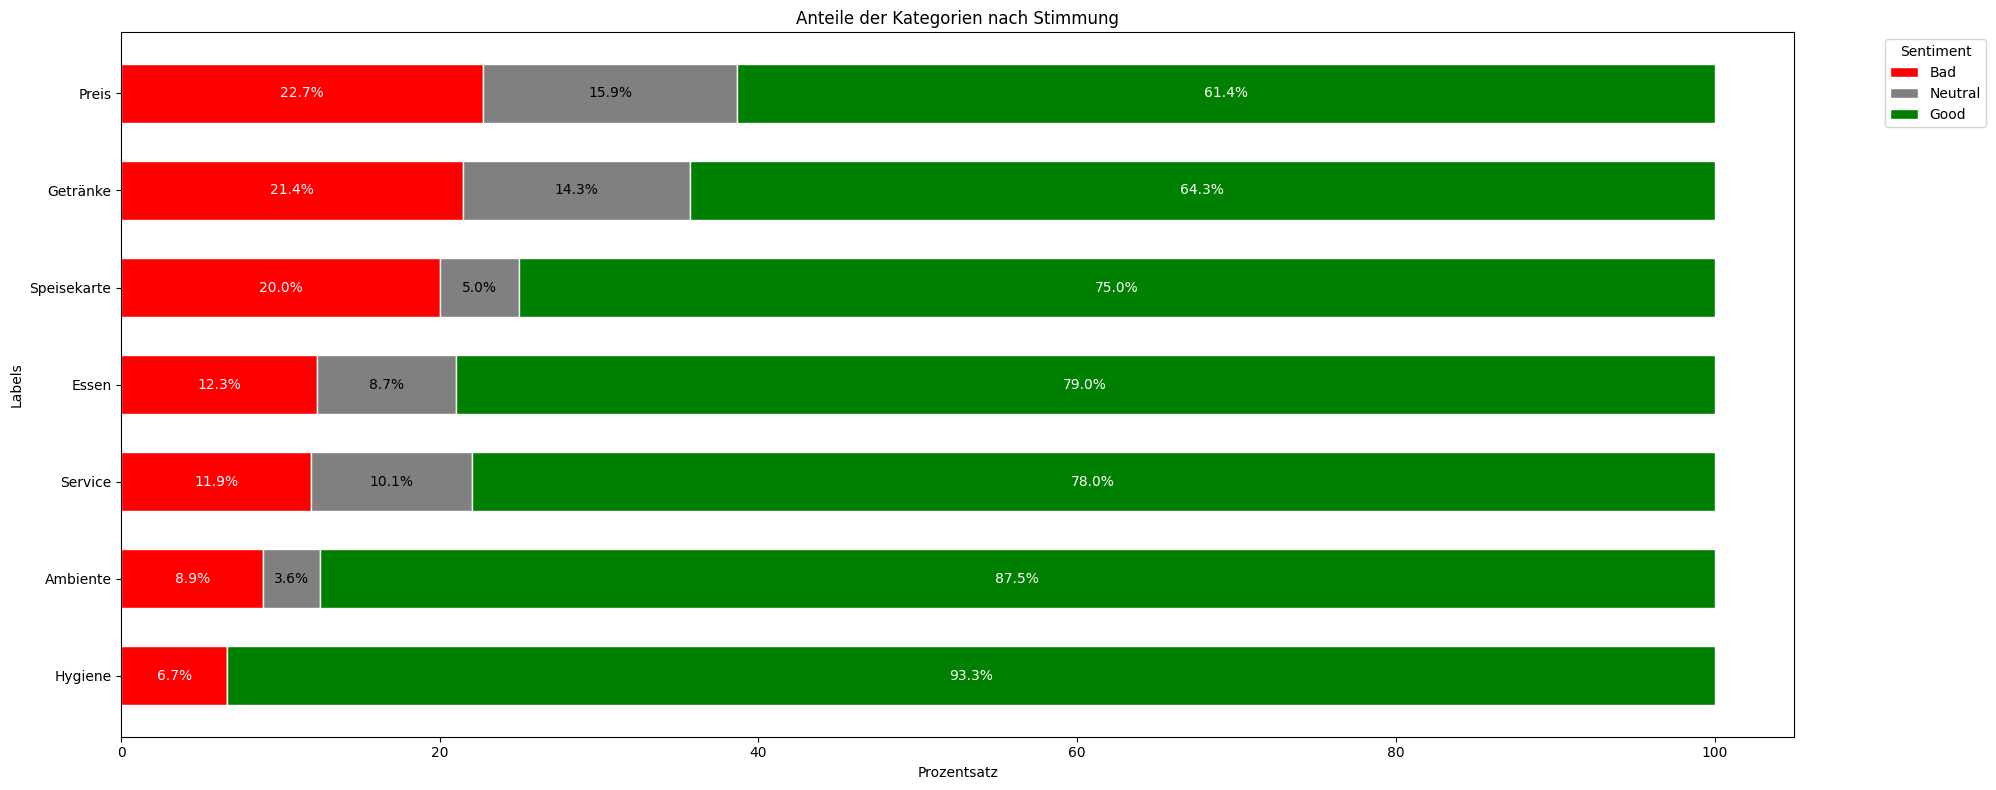

In [ ]:
sentiment_percentages.loc[sorted_labels].plot(kind='barh', stacked=True, color=['red', 'green', 'grey'], ax=ax)
sorted_labels = sentiment_percentages.sort_values(by='bad', ascending=False).index

# Create a stacked bar chart
fig, ax = plt.subplots(figsize=(20, 8))

bar_width = 0.6
index = range(len(sorted_labels))

# Create the bars for each sentiment with 'neutral' in between 'bad' and 'good'
bars_bad = ax.barh(index, sentiment_percentages.loc[sorted_labels, 'bad'], color='red', edgecolor='white', height=bar_width, label='Bad')
bars_neutral = ax.barh(index, sentiment_percentages.loc[sorted_labels, 'neutral'], left=sentiment_percentages.loc[sorted_labels, 'bad'], color='grey', edgecolor='white', height=bar_width, label='Neutral')
bars_good = ax.barh(index, sentiment_percentages.loc[sorted_labels, 'good'], left=sentiment_percentages.loc[sorted_labels, 'bad'] + sentiment_percentages.loc[sorted_labels, 'neutral'], color='green', edgecolor='white', height=bar_width, label='Good')

# Add percentage annotations inside each bar section
for i, (bar_bad, bar_neutral, bar_good) in enumerate(zip(bars_bad, bars_neutral, bars_good)):
    # Calculate the middle position for the bad sentiment text
    bad_mid = bar_bad.get_width() / 2
    if bar_bad.get_width() > 1:  # Ensure there's enough room to place the text
        ax.text(bad_mid, i, f'{bar_bad.get_width():.1f}%', ha='center', va='center', color='white')

    # Calculate the middle position for the neutral sentiment text
    neutral_mid = bar_bad.get_width() + bar_neutral.get_width() / 2
    if bar_neutral.get_width() > 1:  # Ensure there's enough room to place the text
        ax.text(neutral_mid, i, f'{bar_neutral.get_width():.1f}%', ha='center', va='center', color='black')

    # Calculate the middle position for the good sentiment text
    good_mid = bar_bad.get_width() + bar_neutral.get_width() + bar_good.get_width() / 2
    if bar_good.get_width() > 1:  # Ensure there's enough room to place the text
        ax.text(good_mid, i, f'{bar_good.get_width():.1f}%', ha='center', va='center', color = "white")
# Customize the plot
ax.set_xlabel('Prozentsatz')
ax.set_ylabel('Labels')
ax.set_yticks(index)
ax.set_yticklabels(sorted_labels)
ax.set_title('Anteile der Kategorien nach Stimmung')
ax.legend(title='Sentiment', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.gca().invert_yaxis()  # To match the order in your example, highest at the top
plt.tight_layout()

# Display the plot
plt.show()

In [ ]:
# Assuming df_exploded has a 'review_date' column in datetime format
# Make sure 'review_date' is in datetime format
df_exploded['review_date'] = pd.to_datetime(df_exploded['review_date'])

# Calculate the total number of reviews
total_reviews = len(df_exploded)

# Calculate the number of months in the dataset
start_date = df_exploded['review_date'].min()
end_date = df_exploded['review_date'].max()
total_months = ((end_date.year - start_date.year) * 12 + end_date.month - start_date.month + 1)

# Calculate the average number of reviews per month
average_reviews_per_month = total_reviews / total_months

print(f'Average number of reviews per month: {average_reviews_per_month}')

Average number of reviews per month: 30.46153846153846


## Analysis Named Entity Recognition

In [ ]:
from collections import Counter


In [ ]:
import ast
def count_occurrences(df, column):
    count = Counter()
    for row in df[column]:
        if row:  # This checks if the list is not empty
            # Convert string representation of list to actual list
            items = ast.literal_eval(row)
            for item in items:
                count[item] += 1
    return count

# Applying the function to each column
personal_counts = count_occurrences(df_classified_ner, 'Personal')
zutaten_counts = count_occurrences(df_classified_ner, 'Zutaten')
zeiten_counts = count_occurrences(df_classified_ner, 'Zeiten')

print("Counts in Personal:", personal_counts)
print("Counts in Zutaten:", zutaten_counts)
print("Counts in Zeiten:", zeiten_counts)

Counts in Personal: Counter({'Service': 10, 'Personal': 10, 'Bedienung': 5, 'Das Personal': 3, 'Kellnerin': 3, 'nette Bedienung': 2, 'Toller Service': 2, 'sehr nette Bedienung': 2, 'Servicekrfte': 2, 'Koch': 2, 'Barkeeper': 2, 'sie': 2, 'netter Service': 1, 'Kellner': 1, 'freundliches Team': 1, 'Team': 1, 'Timo': 1, 'Alvaro': 1, 'Freundlicher Service': 1, 'Super freundliche Bedienung': 1, 'Auerordentlich nette Bedienung': 1, 'Bedienungen': 1, 'Sehr aufmerksames nettes Personal': 1, 'aufmerksame Bedienung': 1, 'super Personal': 1, 'Super Service': 1, 'freundliches Personal': 1, 'Sehr sympathisches Mitarbeiter': 1, 'Der Service': 1, 'toller Bedienung': 1, 'Die Dame am Empfang': 1, 'Die Servicekrfte': 1, 'sympathische Bedienung': 1, 'super Service': 1, 'Aufmerksames, uerst freundliches Personal': 1, 'Sehr freundliche Bedienung': 1, 'kompetente Hilfe': 1, 'engagierter Service': 1, 'Wir': 1, 'schnelle und freundliche Bedienung': 1, 'Gäste': 1, 'nettes Personal': 1, 'sehr freundlichem Person

In [ ]:
def normalize(text):
    # Convert to lowercase
    text = text.lower()
    # Remove special characters/whitespace
    text = ''.join(e for e in text if e.isalnum() or e.isspace())
    # Handle common misspellings or variations
    misspellings = {
        'hummus': ['humus', 'hummous',"warmer hummus","bester hummus"],
        'blumenkohl': ['gebratenem blumenkohl'],  # Adding German translation example
        'hähnchen': ['hhnchen',"hhnchenspiess"],
        'aubergine': ['auberginen',"auberginengericht"],
        'kichererbsen': ['chickpeas in a pot',"chickpeas"],
        'brot': ['sehr leckeres brot',"sauerbrot"],
        'kartoffel': ['pellkartoffeln',"ofenkartoffel","gedämpftengedünsteten kartoffeln"],
        'fleisch': ['fleischgerichten',"fleischgerichte"],
        'tonkabohnendessert': ["tonkabohnentarte"]

    }
    for correct, variants in misspellings.items():
        if text in variants:
            text = correct
    return text

def count_occurrences(df, column):
    count = Counter()
    for row in df[column]:
        if row:  # This checks if the list is not empty
            items = ast.literal_eval(row)
            for item in items:
                normalized_item = normalize(item)
                count[normalized_item] += 1
    return count

# Applying the function to each column
zutaten_counts = count_occurrences(df_classified_ner, 'Zutaten')

print("Counts in Zutaten:", zutaten_counts)

Counts in Zutaten: Counter({'hummus': 6, 'kartoffel': 4, 'fisch': 4, 'wein': 4, 'blumenkohl': 3, 'aubergine': 3, 'fleisch': 3, 'zatar': 2, 'tonkabohnendessert': 2, 'eiswrfel': 2, 'brot': 2, 'kichererbsen': 2, 'oliven': 2, 'koriander': 2, 'buchweizen': 2, 'olivenl': 1, 'arak': 1, 'anisschnaps': 1, 'lakritze': 1, 'drogenleichen': 1, 'hähnchen': 1, 'pilzfalafel': 1, 'tahini': 1, 'joghurtsauce': 1, 'basil smash': 1, 'interessante gut gewrzte gerichte': 1, 'einzelnen zutaten': 1, 'chicken wings': 1, 'frisches essen': 1, 'spannende speisen': 1, 'tomatensauce': 1, 'zitrone': 1, 'knoblauch': 1, 'chili': 1, 'vegetarisch': 1, 'vegan': 1, 'fnf beeren': 1, 'gorgonzola': 1, 'rind': 1, 'bierbnken': 1, 'caesar salad': 1, 'kartoffelgericht': 1, 'sehr leckeres essen': 1, 'burrito': 1, 'hühnchen': 1, 'harissa': 1, 'essen': 1, 'getränke': 1, 'gebratene zwiebeln': 1, 'mayodipsauce': 1, 'leckerem essen': 1, 'saure sahne': 1, 'holzstühle': 1, 'filzgleiter': 1, 'aniscocktails': 1, 'falafel': 1, 'fischeintopf

In [ ]:
import networkx as nx

def build_network(df, column, unwanted_items=None):
    G = nx.Graph()
    for row in df[column]:
        try:
            items = ast.literal_eval(row)  # Convert string to list
        except Exception as e:
            print(f"Error processing row {row}: {e}")
            continue

        normalized_items = [normalize(item) for item in items if normalize(item) not in (unwanted_items or [])]
        unique_items = set(normalized_items)  # Ensure unique items per row

        for item1 in unique_items:
            for item2 in unique_items:
                if item1 != item2:
                    if G.has_edge(item1, item2):
                        G[item1][item2]['weight'] += 1
                    else:
                        G.add_edge(item1, item2, weight=1)
    return G


def visualize_network(G):
    plt.figure(figsize=(14, 14))  # Increase figure size for better visibility
    # Use the Kamada-Kawai layout to spread out nodes
    pos = nx.kamada_kawai_layout(G, scale=2)  # Adjust scale for better spacing
    edge_weights = [G[u][v]['weight'] for u, v in G.edges()]

    # Draw the network
    nx.draw_networkx_edges(G, pos, alpha=0.3, width=edge_weights, edge_color=edge_weights, style='dotted')
    nx.draw_networkx_nodes(G, pos, node_size=[G.degree(v) * 100 for v in G], node_color='skyblue', alpha=0.6)

    # Draw labels with a white background for better readability
    for key, value in pos.items():
        x, y = value[0], value[1]
        plt.text(x, y, s=key, horizontalalignment='center', fontsize=12)

    plt.title("Co-occurrence Network of Food Items")
    plt.axis("off")
    plt.show()



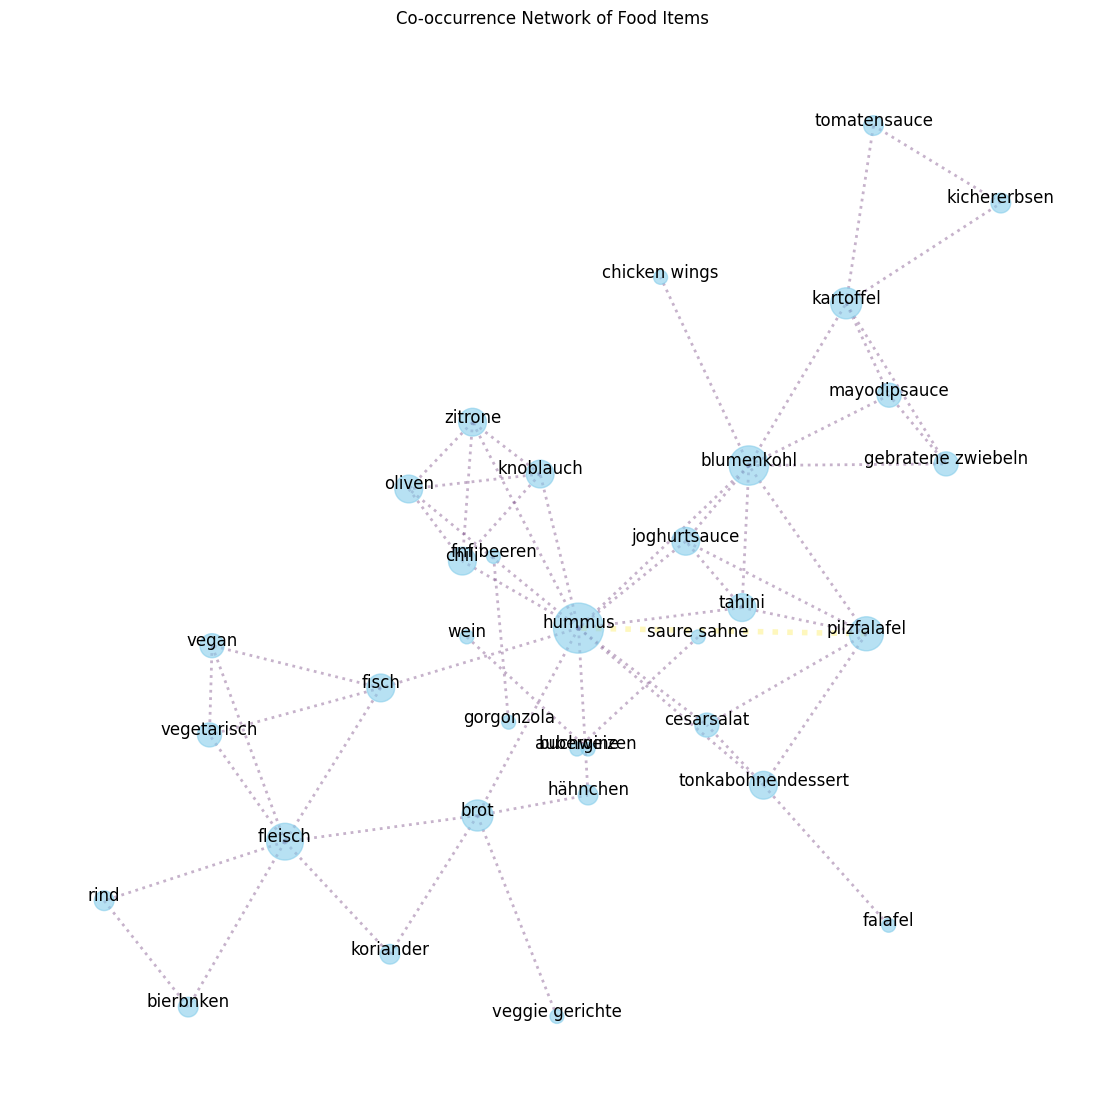

In [ ]:
unwanted_items = ['interessante gut gewrzte gerichte', 'einzelnen zutaten','frisches essen','spannende speisen','unbekannten zutaten',"essen",'getränke','leckerem essen','holzstühle','gutes essen','originelle speisekarte']  # List of items you want to exclude
network = build_network(df_classified_ner, 'Zutaten',unwanted_items)
visualize_network(network)

# Semantic Kernel

In [ ]:
pip install openai

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 325.5/325.5 kB 6.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 75.6/75.6 kB 6.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 77.9/77.9 kB 6.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.3/58.3 kB 7.4 MB/s eta 0:00:00


In [ ]:
file_path = '/content/drive/My Drive/Barshuka/df_classified_ner.csv'
df_classified_ner = pd.read_csv(file_path)

In [ ]:
df_classified_ner.head()

,source,venue_name,review_date,overall_rating,food,service,ambience,noise_text,answer,wait staff_name,...,nps_answer,nps_type,response,language_label,translated_text,labels,labels_score,Personal,Zutaten,Zeiten
0,Google,BarShuka,2024-06-04,4,NaN,NaN,NaN,NaN,"Super Lokal im Bahnhofviertel, um lecker Essen...",NaN,...,NaN,NaN,NaN,de,"Super Lokal im Bahnhofviertel, um lecker Essen...","('Essen', 'Hygiene')","(0.9901278614997864, 0.9019485116004944)",[],[],[]
1,Google,BarShuka,2024-06-01,4,NaN,NaN,NaN,NaN,"Guter, schneller und netter Service. Sehr schn...",NaN,...,NaN,NaN,NaN,de,"Guter, schneller und netter Service. Sehr schn...","('Service', 'Essen', 'Hygiene', 'Ambiente')","(0.9916689395904541, 0.9890152812004089, 0.563...",[],[],[]
2,Google,BarShuka,2024-05-31,1,NaN,NaN,NaN,NaN,Waren heute in der Gruppe um 19 Uhr bei euch g...,NaN,...,NaN,NaN,"Hi Mario,\nmein Name ist James und ich bin ein...",de,Waren heute in der Gruppe um 19 Uhr bei euch g...,"('Hygiene',)","(0.34366685152053833,)",[],[],[]
3,Google,BarShuka,2024-05-25,5,NaN,NaN,NaN,NaN,"Netter Empfang und sofern Platz ist, kann man ...",NaN,...,NaN,NaN,NaN,de,"Netter Empfang und sofern Platz ist, kann man ...","('Speisekarte', 'Preis')","(0.7329637408256531, 0.7232328653335571)",[],[],[]
4,OpenTable,BarShuka,2024-05-22,5,5.0,5.0,5.0,Quiet,"1: Immer wieder ganz wunderbar, um mit Freunde...",NaN,...,NaN,NaN,NaN,de,"1: Immer wieder ganz wunderbar, um mit Freunde...","('Essen',)","(0.9937493205070496,)",[],[],[]


In [ ]:
def filter_by_label(df, label):
    # Filter the DataFrame rows where the label is in the 'Labels' column
    filtered_df = df_classified_ner[df_classified_ner['labels'].apply(lambda x: label in eval(x))]
    return filtered_df

# Example usage
label_to_filter = 'Ambiente'
filtered_df = filter_by_label(df_classified_ner, label_to_filter)
filtered_df.shape
filtered_df.head(5)

,source,venue_name,review_date,overall_rating,food,service,ambience,noise_text,answer,wait staff_name,...,nps_answer,nps_type,response,language_label,translated_text,labels,labels_score,Personal,Zutaten,Zeiten
1,Google,BarShuka,2024-06-01,4,NaN,NaN,NaN,NaN,"Guter, schneller und netter Service. Sehr schn...",NaN,...,NaN,NaN,NaN,de,"Guter, schneller und netter Service. Sehr schn...","('Service', 'Essen', 'Hygiene', 'Ambiente')","(0.9916689395904541, 0.9890152812004089, 0.563...",[],[],[]
5,Google,BarShuka,2024-05-22,5,NaN,NaN,NaN,NaN,Ich was spontan mit etwas Hunger zur Mittagsze...,NaN,...,NaN,NaN,NaN,de,Ich was spontan mit etwas Hunger zur Mittagsze...,"('Ambiente', 'Speisekarte')","(0.9948623180389404, 0.5205345749855042)",[],[],['Mittagszeit']
18,Google,BarShuka,2024-04-07,2,NaN,NaN,NaN,NaN,Ehemals solides Restaurant hat leider qualitat...,NaN,...,NaN,NaN,"Lieber Alex Meier, vielen Dank für Ihr Feedbac...",de,Ehemals solides Restaurant hat leider qualitat...,"('Ambiente', 'Essen', 'Service')","(0.9894183874130249, 0.780846357345581, 0.6495...",['Bedienung'],"['Olivenl', 'Arak', 'Anisschnaps', 'Lakritze',...",[]
32,OpenTable,BarShuka,2024-02-29,5,5.0,5.0,5.0,Quiet,"1: Unser Besuch war super. Leckeres Essen, tol...",NaN,...,NaN,NaN,NaN,de,"1: Unser Besuch war super. Leckeres Essen, tol...","('Essen', 'Ambiente', 'Service', 'Hygiene')","(0.9939491748809814, 0.9764964580535889, 0.765...",[],[],[]
38,Google,BarShuka,2024-02-18,4,NaN,NaN,NaN,NaN,Ambiente und Qualitt der Speisen hervorragend....,NaN,...,NaN,NaN,NaN,de,Ambiente und Qualitt der Speisen hervorragend....,"('Ambiente', 'Preis', 'Speisekarte')","(0.9723979830741882, 0.8831790089607239, 0.635...",[],[],[]


In [ ]:
# Define the function to calculate the number of tokens
def count_tokens(text):
    return len(text.split())


In [ ]:
reviews = filtered_df['translated_text'].tolist()

# Calculate the approximate number of tokens
concatenated_reviews = "\n\n".join(reviews)
token_count = count_tokens(concatenated_reviews)
token_count

1895

In [ ]:
from openai import OpenAI
import openai
from openai import OpenAI

# Replace 'YOUR_API_KEY' with your actual OpenAI API key
client = OpenAI(api_key= "put your api-key")

def summarize_reviews(reviews,topic,df):


    # Prepare the messages for the API call
    messages = [
        {"role": "system", "content": "Du bist ein hilfreicher Assistent."},
        {"role": "user", "content": f"Bitte schreibe eine kurze allgemeine Zusammenfassung der Reviews über dieses Thema: {topic}. Sprich nur dinge an die im direkten bezug zum {topic} liegen bei essen zum beispiel Zutaten aber nicht lautstärke oder ambiente .Probier Gemeinsamkeiten in den Reviews zu finden wie zum Beispiel, die meisten reviews finden das Essen sehr frisch. "},
        {"role": "user", "content": "\n\n".join(reviews)}
    ]

    # Make the API call to create a completion
    response = client.chat.completions.create(
        model="gpt-4o",
        messages=messages
    )

    # Extract and return the assistant's response
    summary = response.choices[0].message.content
    return summary



In [ ]:
#candidate_labels = ["Essen","Getränke","Service","Speisekarte","Preis","Hygiene","Ambiente"]


In [ ]:
summary = summarize_reviews(reviews, "Essen", filtered_df)
print(summary)

Die Reviews über das Essen in diesem Restaurant zeigen eine starke Varianz in den Meinungen, aber es gibt einige klare Trends und Gemeinsamkeiten:

1. **Hervorragender Geschmack und Qualität**: Viele Gäste betonen, dass das Essen sehr lecker ist und die Gerichte gut zubereitet sind. Besondere Erwähnung finden der Hummus und einige der kreativen israelischen Gerichte.

2. **Große Vielfalt und besondere Weine**: Eine große Auswahl an einzigartigen Gerichten und Weine, insbesondere libanesische, wird häufig gelobt. Viele Gäste schätzen die originellen und vielfältigen Optionen auf der Speisekarte.

3. **Frische Zutaten**: Zahlreiche Reviews heben die Frische der Zutaten hervor, was in den positiven Bewertungen oft betont wird.

4. **Preis-Leistungs-Verhältnis**: Viele Gäste empfinden die Preise als hoch, vor allem im Verhältnis zur Portionsgröße. Kleinere Portionen und höhere Preise sind häufige Kritikpunkte.

5. **Inkonsistente Portionen und Qualität**: Es gibt Berichte über nicht gleich

In [ ]:
summary = summarize_reviews(reviews, "Service", filtered_df)
print(summary)

Die zentralen Gemeinsamkeiten der Reviews in Bezug auf den Service in dem Restaurant lassen sich wie folgt zusammenfassen:

1. **Freundlicher und herzlicher Service**: Viele Bewertungen loben das Personal für seine Freundlichkeit und Aufmerksamkeit. Sätze wie "sehr freundlicher Service", "Service sehr nett" und "außergewöhnlich guter Service" sind häufig zu lesen.

2. **Effizienz und Geschwindigkeit**: Mehrere Gäste äußern sich positiv zur Schnelligkeit des Services, insbesondere bei Bestellungen und der Bedienung. Kommentare wie "Service sehr schnell und freundlich" und "Essen kam schnell (Mittagspause!)" unterstützen dies.

3. **Inkonsistenz und Überforderung**: Auf der anderen Seite gibt es mehrere Hinweise darauf, dass der Service manchmal unaufmerksam oder überfordert wirkt. Begriffe wie "Service hatte null Interesse und null Lust" oder "Service unaufmerksam und überfordert" wurden wiederholt erwähnt.

4. **Probleme bei der Reservierung und Tischzuteilung**: Einige Reviews bemänge

In [ ]:
summary = summarize_reviews(reviews, "Preis", filtered_df)
print(summary)

Basierend auf den verschiedenen Rezensionen über den Preis in Bezug auf das Essen lassen sich mehrere Gemeinsamkeiten feststellen:

1. **Hohes Preisniveau**: Viele Bewertungen geben an, dass die Preise als hoch empfunden werden. Dies gilt insbesondere für Hauptgerichte und Cocktails.
   
2. **Preis-Leistungs-Verhältnis**: Ein wiederkehrendes Thema ist die Wahrnehmung eines schlechten Preis-Leistungs-Verhältnisses. Die Portionen werden oft als zu klein für den verlangten Preis beschrieben, was dazu führt, dass Gäste das Restaurant hungrig verlassen.
   
3. **Qualität des Essens**: Während einige Gäste den Geschmack des Essens loben und die Qualität als hoch einstufen, gibt es auch gegenteilige Meinungen, die das Essen als nichts Besonderes oder sogar enttäuschend bewerten, besonders für den hohen Preis.
   
4. **Getränke**: Es gibt Kritik hinsichtlich der Getränke, insbesondere der Cocktails, die als zu teuer und manchmal nicht angemessen serviert (zu viel Eis, zu kleines Glas) beschrie

In [ ]:
summary = summarize_reviews(reviews, "Ambiente", filtered_df)
print(summary)

Beim Durchgehen der Reviews fällt auf, dass das Ambiente der Bar Shuka überwiegend positiv bewertet wird. Hier sind einige der häufig genannten Punkte:

1. **Allgemeine Atmosphäre**:
   - Viele Gäste betonen die schöne und angenehme Atmosphäre des Lokals. Es wird oft als modern, schick und cool beschrieben.
   - Das Ambiente wird als lebhaft und gastfreundlich wahrgenommen.
   - Einige Reviews erwähnen eine gewisse Lautstärke im Lokal, dies wird jedoch meist nicht als größeres Problem dargestellt.

2. **Einrichtung und Dekor**:
   - Die Einrichtung wird häufig gelobt. Der Stil wird als klassisch modern, "shabby chic" und bunt-authentisch beschrieben.
   - Die Dekoration und das Interieur tragen maßgeblich zur positiven Bewertung des Ambientes bei.

3. **Gästebereich und Sitzgelegenheiten**:
   - Die verschiedenen Bereiche, wie der Innenhof und die Dachterrasse, werden unterschiedlich wahrgenommen. Während der Innenhof als schön geschildert wird, wird die Dachterrasse teilweise als etwa

In [ ]:
def swot(reviews):


    # Prepare the messages for the API call
    messages = [
        {"role": "system", "content": "Du bist ein hilfreicher Assistent."},
        {"role": "user", "content": f" Erstelle eine swot analyse aus den Kundenreviews. Stärken und Schwächen: Identifizieren Sie wiederkehrende Themen des Lobes und der Kritik. Chancen: Erkennen Sie unerfüllte Kundenbedürfnisse oder Vorschläge für neue Funktionen/Dienstleistungen. Bedrohungen: Heben Sie Erwähnungen von Wettbewerbern hervor und Bereiche, in denen Wettbewerber möglicherweise besser abschneiden."},
        {"role": "user", "content": "\n\n".join(reviews)}
    ]

    # Make the API call to create a completion
    response = client.chat.completions.create(
        model="gpt-4o",
        messages=messages
    )

    # Extract and return the assistant's response
    summary = response.choices[0].message.content
    return summary


In [ ]:
reviews = df_classified_ner['translated_text'].tolist()


In [ ]:
def designthinking(reviews, topic):


    # Prepare the messages for the API call
    messages = [
        {"role": "system", "content": "Du bist ein hilfreicher Assistent."},
        {"role": "user", "content": f"Bitte schreibe eine kurze allgemeine Zusammenfassung der Reviews über dieses Thema: {topic}. Sprich nur dinge an die im direkten bezug zum {topic} liegen.Probier Gemeinsamkeiten in den Reviews zu finden wie zum Beispiel, die meisten reviews finden das Essen sehr frisch. Maximal 3 sätze "},
        {"role": "user", "content": "\n\n".join(reviews)}
    ]

    # Make the API call to create a completion
    response = client.chat.completions.create(
        model="gpt-4o",
        messages=messages
    )

    # Extract and return the assistant's response
    summary = response.choices[0].message.content
    return summary

designthinking(reviews, "Lautstärke")

'In den meisten Reviews zur Lautstärke des Lokals wird erwähnt, dass es generell recht laut ist, insbesondere durch Musik und Geräusche von Gästen und Interaktionen im Restaurant. Viele Gäste haben hervorgehoben, dass die Lautstärke Gespräche erschwert und es teilweise anstrengend macht, sich zu unterhalten. Jedoch gibt es auch vereinzelte Hinweise darauf, dass die Geräuschkulisse zur lebendigen Atmosphäre des Lokals beiträgt.'

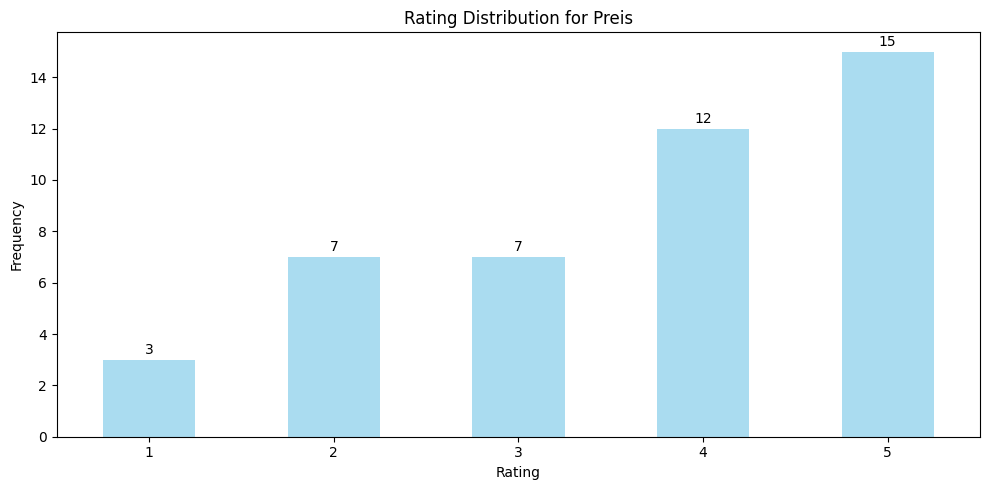

In [ ]:
def plot_rating_distribution(df, topic, labels_column, rating_column):
    # Filter reviews that mention the specific topic
    topic_reviews = df[df[labels_column].apply(lambda x: topic in eval(x))]

    # Count the number of reviews for each rating
    rating_counts = topic_reviews[rating_column].value_counts().sort_index()

    # Plot the distribution
    plt.figure(figsize=(10, 5))
    rating_counts.plot(kind='bar', color='skyblue', alpha=0.7)
    plt.xlabel('Rating')
    plt.ylabel('Frequency')
    plt.title(f'Rating Distribution for {topic}')
    plt.xticks(rotation=0)
    for i, v in enumerate(rating_counts):
        plt.text(i, v + 0.1, str(v), ha='center', va='bottom')
    plt.tight_layout()
    plt.show()



plot_rating_distribution(df_classified_ner, "Preis", "labels", "overall_rating")

In [ ]:
# Ensure the review date column is in datetime format
df_classified_ner['review_date'] = pd.to_datetime(df_classified_ner['review_date'])
# Function to explode the labels into separate rows
def explode_labels(df, labels_column):
    exploded_df = df.copy()
    exploded_df[labels_column] = exploded_df[labels_column].apply(eval)  # Convert string representation of list to actual list
    exploded_df = exploded_df.explode(labels_column)
    return exploded_df

# Explode the labels column
df_exploded = explode_labels(df_classified_ner, 'labels')

# Set the review date as the index
df_exploded.set_index('review_date', inplace=True)

# Resample by month and count the occurrences of each label
monthly_counts = df_exploded.groupby('labels').resample('M').size()

# Calculate the average number of reviews per label per month
average_reviews_per_label_per_month = monthly_counts.groupby('labels').mean()

# Display the result
print(average_reviews_per_label_per_month)

# Optionally, you can reset the index and convert the result to a DataFrame for better readability
average_reviews_df = average_reviews_per_label_per_month.reset_index()
average_reviews_df.columns = ['Label', 'Average Reviews per Month']

print(average_reviews_df)

labels
Ambiente        4.307692
Essen          10.615385
Getränke        1.166667
Hygiene         1.153846
Preis           3.666667
Service         8.384615
Speisekarte     1.538462
dtype: float64
         Label  Average Reviews per Month
0     Ambiente                   4.307692
1        Essen                  10.615385
2     Getränke                   1.166667
3      Hygiene                   1.153846
4        Preis                   3.666667
5      Service                   8.384615
6  Speisekarte                   1.538462


In [ ]:
df_classified_ner['review_date'] = pd.to_datetime(df_classified_ner['review_date'])

# Function to explode the labels into separate rows
def explode_labels(df, labels_column):
    exploded_df = df.copy()
    exploded_df[labels_column] = exploded_df[labels_column].apply(eval)  # Convert string representation of list to actual list
    exploded_df = exploded_df.explode(labels_column)
    return exploded_df

# Explode the labels column
df_exploded = explode_labels(df_classified_ner, 'labels')

# Function to get the number of reviews per label in a specific month and year
def get_reviews_per_label_in_month(df, year, month, labels_column):
    specific_month_reviews = df.loc[(df.index.year == year) & (df.index.month == month)]
    label_counts = specific_month_reviews[labels_column].value_counts()
    return label_counts

# Replace with the desired year, month
year = 2024
month = 5

# Set the review date as the index
df_exploded.set_index('review_date', inplace=True)

# Get the number of reviews per label in the specified month
label_counts = get_reviews_per_label_in_month(df_exploded, year, month, 'labels')

print(f"The number of reviews per label for {year}-{month:02d} is:")
print(label_counts)

# Optionally, convert the result to a DataFrame for better readability
label_counts_df = label_counts.reset_index()
label_counts_df.columns = ['Label', 'Count']

print(label_counts_df)

The number of reviews per label for 2024-05 is:
labels
Essen          7
Speisekarte    3
Ambiente       3
Hygiene        2
Preis          2
Service        2
Getränke       1
Name: count, dtype: int64
         Label  Count
0        Essen      7
1  Speisekarte      3
2     Ambiente      3
3      Hygiene      2
4        Preis      2
5      Service      2
6     Getränke      1


In [ ]:
# Function to get the average rating per column in a specific month and year
def get_average_ratings_in_month(df, year, month, columns):
    specific_month_reviews = df.loc[(df['review_date'].dt.year == year) & (df['review_date'].dt.month == month)]
    average_ratings = specific_month_reviews[columns].mean()
    return average_ratings

# Replace with the desired year and month
year = 2024
month = 5

# Columns to calculate the average ratings for
columns = ['food', 'service', 'ambience']

# Get the average ratings for the specified month
average_ratings = get_average_ratings_in_month(df_classified_ner, year, month, columns)

print(f"The average ratings for {year}-{month:02d} are:")
print(average_ratings)

The average ratings for 2024-05 are:
food        4.75
service     4.50
ambience    4.75
dtype: float64
